# I. Preparation

In [33]:
import os
import h5py
import time
import itertools

from math import log, sqrt
from statistics import stdev, variance, mean

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from scipy import signal
from scipy.stats import ttest_ind

import statsmodels.api as sm
from statsmodels.formula.api import ols
from statsmodels.stats.outliers_influence import variance_inflation_factor
from statsmodels.stats.multicomp import pairwise_tukeyhsd

from sklearn.model_selection import StratifiedKFold, GridSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression, RidgeClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.metrics import classification_report
from sklearn.inspection import permutation_importance

from fooof import FOOOF, FOOOFGroup
from fooof.plts.spectra import plot_spectrum, plot_spectrum_shading, plot_spectra, plot_spectra_shading
from fooof.analysis import get_band_peak_fm, get_band_peak_fg
from fooof.plts.periodic import plot_peak_fits, plot_peak_params
from fooof.plts.aperiodic import plot_aperiodic_params, plot_aperiodic_fits
from fooof.objs.utils import combine_fooofs

from neurodsp.filt import filter_signal
from neurodsp.utils import create_times
from neurodsp.plts.time_series import plot_time_series
from neurodsp.spectral import compute_spectrum

## 1. Function to read .mat files

In [34]:
def read_matlab(filename):
    def conv(path=''):
        p = path or '/'
        paths[p] = ret = {}
        for k, v in f[p].items():
            if type(v).__name__ == 'Group':
                ret[k] = conv(f'{path}/{k}')  # Nested struct
                continue
            v = v[()]  # It's a Numpy array now
            if v.dtype == 'object':
                # HDF5ObjectReferences are converted into a list of actual pointers
                ret[k] = [r and paths.get(f[r].name, f[r].name) for r in v.flat]
            else:
                # Matrices and other numeric arrays
                ret[k] = v if v.ndim < 2 else v.swapaxes(-1, -2)
        return ret

    paths = {}
    with h5py.File(filename, 'r') as f:
        return conv()

## 2. Parameters that can be changed

In [35]:
# Days
days = ('/Day1', '/Day2')

# Subjects
subjects = ['S1', 'S2', 'S3', 'S4', 'S5', 'S6', 'S7', 'S8', 'S9', 'S10', 
            'S11', 'S12', 'S13', 'S14', 'S15', 'S16', 'S17', 'S18', 'S19', 'S20', 
            'S21', 'S22', 'S23', 'S24', 'S25', 'S26', 'S27', 'S28', 'S29', 'S30']

In [36]:
# Parieto, parieto-occipital and occipital channels
channels = (17,18,19,20,21,22,23,24,25,26,27,29,30)
n_channels = 13

In [37]:
table = 4

# Frequency range to fit FOOOF model: Low, Mid, or High
fr = (10, 50)

# Frequency range from which to collect Gaussians
bn = (18,24)

## 3. Parameters that should stay fixed

In [38]:
# Sampling rate
fs = 200

# nperseg
nperseg = 500

# Set peak_width_limits
pwl = [2, 4]

# Set max_n_peaks
mnp = 5

# Set peak_threshold
pt = 2 

# Initialize dataframe to store variables
df = pd.DataFrame([], index = [], columns = ['subject', 'day', 'target', \
                                             'offset', 'knee', 'exponent', \
                                             'CF', 'PW', 'BW', 'n_peaks', \
                                             'r_squared', 'error'])

# Colors
colors = ['blue', 'yellow', 'green', 'red']

# II. Fourier transform and FOOOF

In [39]:
## Read EEG, calculate PSD (Welch), fit FOOOF

tic = time.time()
for subject in subjects: 
    for day in days:
        # Initialize per target, average over trials and channels
        powers_50 = np.empty((0, int(nperseg//2)+1), float)
        powers_55 = np.empty((0, int(nperseg//2)+1), float)
        powers_60 = np.empty((0, int(nperseg//2)+1), float)
        powers_65 = np.empty((0, int(nperseg//2)+1), float)
        powers_210 = np.empty((0, int(nperseg//2)+1), float)
        powers_215 = np.empty((0, int(nperseg//2)+1), float)
        powers_220 = np.empty((0, int(nperseg//2)+1), float)
        powers_225 = np.empty((0, int(nperseg//2)+1), float)
        powers_400 = np.empty((0, int(nperseg//2)+1), float)
        powers_405 = np.empty((0, int(nperseg//2)+1), float)
        powers_410 = np.empty((0, int(nperseg//2)+1), float)
        powers_415 = np.empty((0, int(nperseg//2)+1), float)

        # Change working directory
        original = os.getcwd()
        os.chdir("C:/Users/ThinkPad/Desktop/Thesis/Data/"+subject+day)

        # Giving directory name
        folderdir = 'C:/Users/ThinkPad/Desktop/Thesis/Data/'+subject+day

        # Giving file extensions
        ext = ('.mat')

        # Iterating over directory
        for path, dirc, files in os.walk(folderdir):
            for file in files:
                if file.endswith(ext) and file.startswith('cnt'):
                    print(subject, day, file)

                    # LOW, MID, or HIGH
                    level = file[4:-7]

                    # Session 1, or session 2
                    session = file[-6]

                    # Read data
                    data = read_matlab(file)['cnt']['x']

                    # Read timestamps 
                    timestamps = (read_matlab(folderdir+'/mrk_'+level+'('+session+').mat')['mrk']['time'])[0]

                    # Read stimuli order
                    order_stimuli = read_matlab(folderdir+'/mrk_'+level+'('+session+').mat')['mrk']['event']['desc']

                    for trial, timestamp in enumerate(timestamps):   
                        if trial%2 == False:
                            start = int(timestamp)
                        else:
                            stop = int(timestamp)

                            for channel in channels:
#                                 # Apply bandpass filter
#                                 data[:,channel] = filter_signal(data[:,channel], fs, 'bandpass', f_range=fr)

                                # Splice data according to timestamps
                                sig = data[:,channel][start:stop]
                                times = create_times(len(sig)/fs, fs)

#                                 # Plot EEG 
#                                 fig, ax = plt.subplots(figsize=[15, 5])
#                                 plot_time_series(times, sig, xlim=[0,len(sig)/fs], ax=ax)
#                                 plt.show()                                

                                # Welch FFT: calculate mean of spectrogram
                                freq, power = signal.welch(sig, fs, window='hann', average='mean', nperseg=nperseg,\
                                                          noverlap=450, detrend='constant')

                                # Append power to previous powers
                                if level=='LOW':
                                    if order_stimuli[trial-1]==[1.]: 
                                        powers_50 = np.append(powers_50, power.reshape(1, len(freq)), axis=0)
                                    elif order_stimuli[trial-1]==[2.]: 
                                        powers_55 = np.append(powers_55, power.reshape(1, len(freq)), axis=0)
                                    elif order_stimuli[trial-1]==[3.]: 
                                        powers_60 = np.append(powers_60, power.reshape(1, len(freq)), axis=0)
                                    elif order_stimuli[trial-1]==[4.]: 
                                        powers_65 = np.append(powers_65, power.reshape(1, len(freq)), axis=0)
                                elif level=='MID':
                                    if order_stimuli[trial-1]==[1.]: 
                                        powers_210 = np.append(powers_210, power.reshape(1, len(freq)), axis=0)
                                    elif order_stimuli[trial-1]==[2.]: 
                                        powers_215 = np.append(powers_215, power.reshape(1, len(freq)), axis=0)
                                    elif order_stimuli[trial-1]==[3.]: 
                                        powers_220 = np.append(powers_220, power.reshape(1, len(freq)), axis=0)
                                    elif order_stimuli[trial-1]==[4.]: 
                                        powers_225 = np.append(powers_225, power.reshape(1, len(freq)), axis=0)
                                elif level=='HIGH':
                                    if order_stimuli[trial-1]==[1.]: 
                                        powers_400 = np.append(powers_400, power.reshape(1, len(freq)), axis=0)
                                    elif order_stimuli[trial-1]==[2.]: 
                                        powers_405 = np.append(powers_405, power.reshape(1, len(freq)), axis=0)
                                    elif order_stimuli[trial-1]==[3.]: 
                                        powers_410 = np.append(powers_410, power.reshape(1, len(freq)), axis=0)
                                    elif order_stimuli[trial-1]==[4.]: 
                                        powers_415 = np.append(powers_415, power.reshape(1, len(freq)), axis=0)

        # Fit FOOOF model per target
        for (powers, target) in zip((powers_210, powers_220, powers_225), \
                                    (210, 220, 225)):
            # FOOOF object: initialize, fit and print results
            fm = FOOOF(aperiodic_mode='knee', peak_width_limits=pwl, max_n_peaks=mnp, peak_threshold=pt, verbose=True)
            fm.fit(freq, np.mean(powers, axis=0), freq_range=fr)
            fm.print_results()
#             fig, ax = plt.subplots(figsize=[15, 5])
#             fm.plot(plot_peaks='line-shade', ax=ax)
#             plt.show()

            # Save metadata, FOOOF parameters and results
            try:
                if np.isnan(get_band_peak_fm(fm, band=bn, select_highest=True)[0])==False:
                    row = pd.DataFrame([subject, day, target, \
                                        fm.aperiodic_params_[0], \
                                        fm.aperiodic_params_[1], \
                                        fm.aperiodic_params_[2], \
                                        get_band_peak_fm(fm, band=bn, select_highest=True)[0], \
                                        get_band_peak_fm(fm, band=bn, select_highest=True)[1], \
                                        get_band_peak_fm(fm, band=bn, select_highest=True)[2], \
                                        fm.n_peaks_,\
                                        fm.r_squared_, \
                                        fm.error_],
                                       index = ['subject', 'day', 'target', \
                                                'offset', 'knee', 'exponent',\
                                                'CF', 'PW', 'BW', 'n_peaks', \
                                                'r_squared', 'error']).transpose()
                    df = df.append(row, ignore_index=True) 
            except:
                pass

# Typecast dataframe
df[['subject', 'day', 'target']] = df[['subject', 'day', 'target']].astype('category')
df['n_peaks'] = df['n_peaks'].astype('int32')
df[['offset', 'knee', 'exponent', 'CF', 'PW', 'BW', 'r_squared', 'error']] = \
df[['offset', 'knee', 'exponent', 'CF', 'PW', 'BW', 'r_squared', 'error']].astype('float32')

# Change working directory back
os.chdir(original)

print(f'Done in {time.time()-tic} seconds')

S1 /Day1 cnt_HIGH(1).mat
S1 /Day1 cnt_HIGH(2).mat
S1 /Day1 cnt_LOW(1).mat
S1 /Day1 cnt_LOW(2).mat
S1 /Day1 cnt_MID(1).mat
S1 /Day1 cnt_MID(2).mat
                                                                                                  
                                   FOOOF - POWER SPECTRUM MODEL                                   
                                                                                                  
                       The model was run on the frequency range 10 - 50 Hz                        
                                 Frequency Resolution is 0.40 Hz                                  
                                                                                                  
                         Aperiodic Parameters (offset, knee, exponent):                           
                                     -2.7861, -1.0137, 0.0059                                     
                                                              

# III. Descriptive statistics
## 1. Summary

In [40]:
# Data types
display(df.dtypes)

subject      category
day          category
target       category
offset        float32
knee          float32
exponent      float32
CF            float32
PW            float32
BW            float32
n_peaks         int32
r_squared     float32
error         float32
dtype: object

In [41]:
# Head of dataframe
display(df.head(n=5))

,subject,day,target,offset,knee,exponent,CF,PW,BW,n_peaks,r_squared,error
0,S1,/Day1,210,-2.786069,-1.013677,0.005934,19.586790,0.252773,3.550318,3,0.971973,0.044624
1,S1,/Day1,220,-1.130506,-1.598865,0.205102,21.920685,0.298087,2.000000,3,0.971127,0.049268
2,S1,/Day1,225,-4.173462,-1.000673,0.000297,20.296577,0.213252,4.000000,5,0.969226,0.047616
3,S1,/Day2,210,-3.396288,-1.002890,0.001265,18.440058,0.231410,2.214785,4,0.966493,0.044092
4,S1,/Day2,220,-3.725321,-1.000896,0.000401,22.025690,0.158610,2.000000,4,0.848166,0.071575


In [42]:
# Summary statistics
display(pd.concat([df.describe(),\
                   pd.DataFrame(df.skew(), columns=['skewness']).transpose(),\
                   pd.DataFrame(df.kurtosis(), columns=['kurtosis']).transpose()]).round(2))

,offset,knee,exponent,CF,PW,BW,n_peaks,r_squared,error
count,176.00,1.760000e+02,176.00,176.00,176.00,176.00,176.00,176.00,176.00
mean,1.90,1.238112e+09,1.85,21.66,0.35,2.63,3.42,0.95,0.06
std,2.56,1.513542e+10,1.32,0.91,0.15,0.82,1.03,0.05,0.02
min,-4.27,-2.790800e+02,0.00,18.44,0.09,2.00,1.00,0.58,0.03
25%,0.43,-7.970000e+00,0.82,20.98,0.24,2.00,3.00,0.95,0.05
50%,1.83,-1.210000e+00,1.73,21.87,0.33,2.00,3.00,0.97,0.05
75%,3.58,5.752400e+02,2.67,22.32,0.43,3.48,4.00,0.98,0.07
max,10.91,2.004331e+11,7.07,23.85,1.00,4.00,5.00,0.99,0.13
skewness,0.25,1.318000e+01,1.11,-0.61,1.25,0.76,-0.07,-3.88,1.21
kurtosis,1.59,1.743600e+02,2.24,0.55,2.85,-1.19,-0.94,19.73,1.38


## 2. Univariate plots

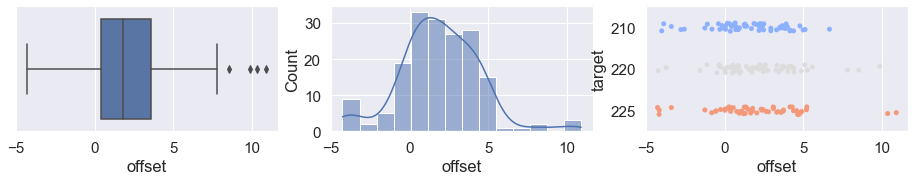

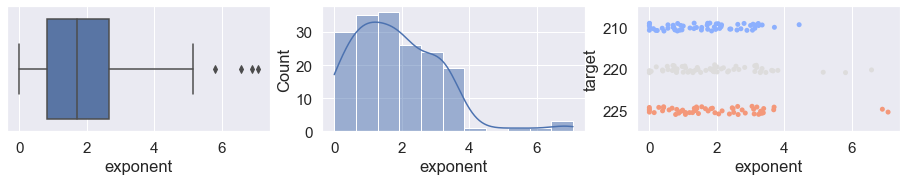

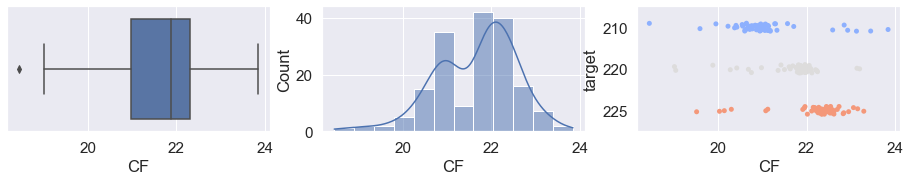

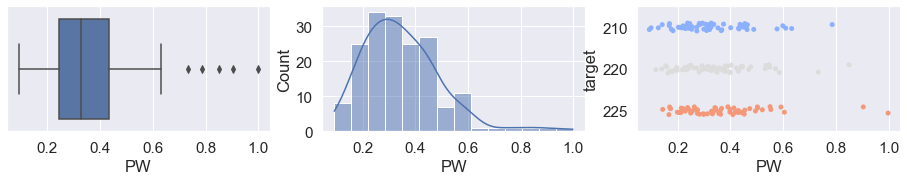

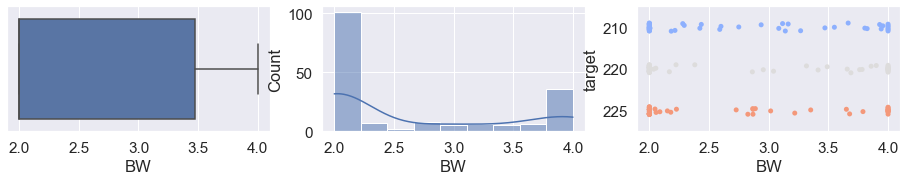

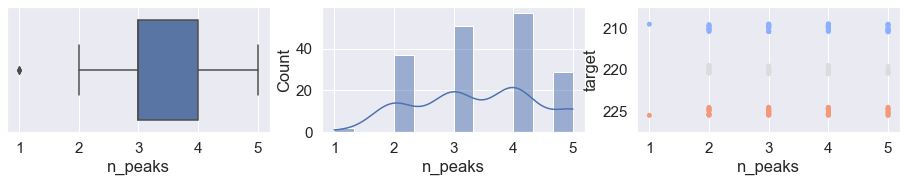

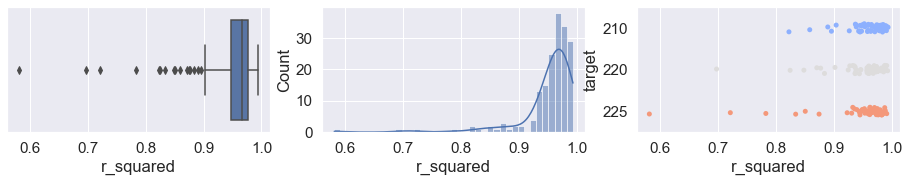

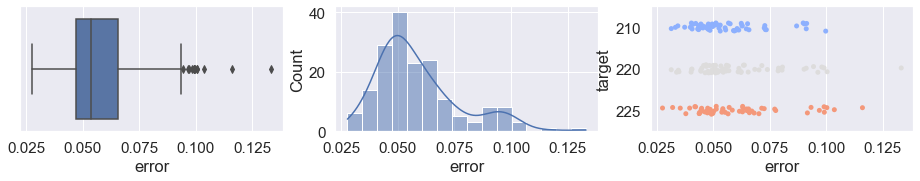

Done in 15.897s


In [43]:
tic = time.time()

df_num = df[['offset', 'exponent', 'CF', 'PW', 'BW', 'n_peaks', 'r_squared', 'error']]

for index, column in enumerate(df_num):
    sns.set(font_scale = 1.38)
    fig, ax = plt.subplots(1, 3, figsize=[16, 2.3])
    sns.boxplot(data=df_num, x=column, ax=ax[0])
    sns.histplot(data=df_num, x=column, kde=True,  ax=ax[1]) 
    sns.stripplot(data=df_num, x=column, y=df['target'], palette='coolwarm', ax=ax[2])
    plt.show()

toc = time.time()
print(f"Done in {toc - tic:.3f}s")

## 3. Bivariate plots

C:\Users\ThinkPad\anaconda3\lib\site-packages\seaborn\distributions.py:1134: UserWarning: cmap parameter ignored when using hue mapping.
  warnings.warn(msg, UserWarning)
C:\Users\ThinkPad\anaconda3\lib\site-packages\seaborn\distributions.py:1134: UserWarning: cmap parameter ignored when using hue mapping.
  warnings.warn(msg, UserWarning)
C:\Users\ThinkPad\anaconda3\lib\site-packages\seaborn\distributions.py:1134: UserWarning: cmap parameter ignored when using hue mapping.
  warnings.warn(msg, UserWarning)
C:\Users\ThinkPad\anaconda3\lib\site-packages\seaborn\distributions.py:1134: UserWarning: cmap parameter ignored when using hue mapping.
  warnings.warn(msg, UserWarning)
C:\Users\ThinkPad\anaconda3\lib\site-packages\seaborn\distributions.py:1134: UserWarning: cmap parameter ignored when using hue mapping.
  warnings.warn(msg, UserWarning)
C:\Users\ThinkPad\anaconda3\lib\site-packages\seaborn\distributions.py:1134: UserWarning: cmap parameter ignored when using hue mapping.
  warnin

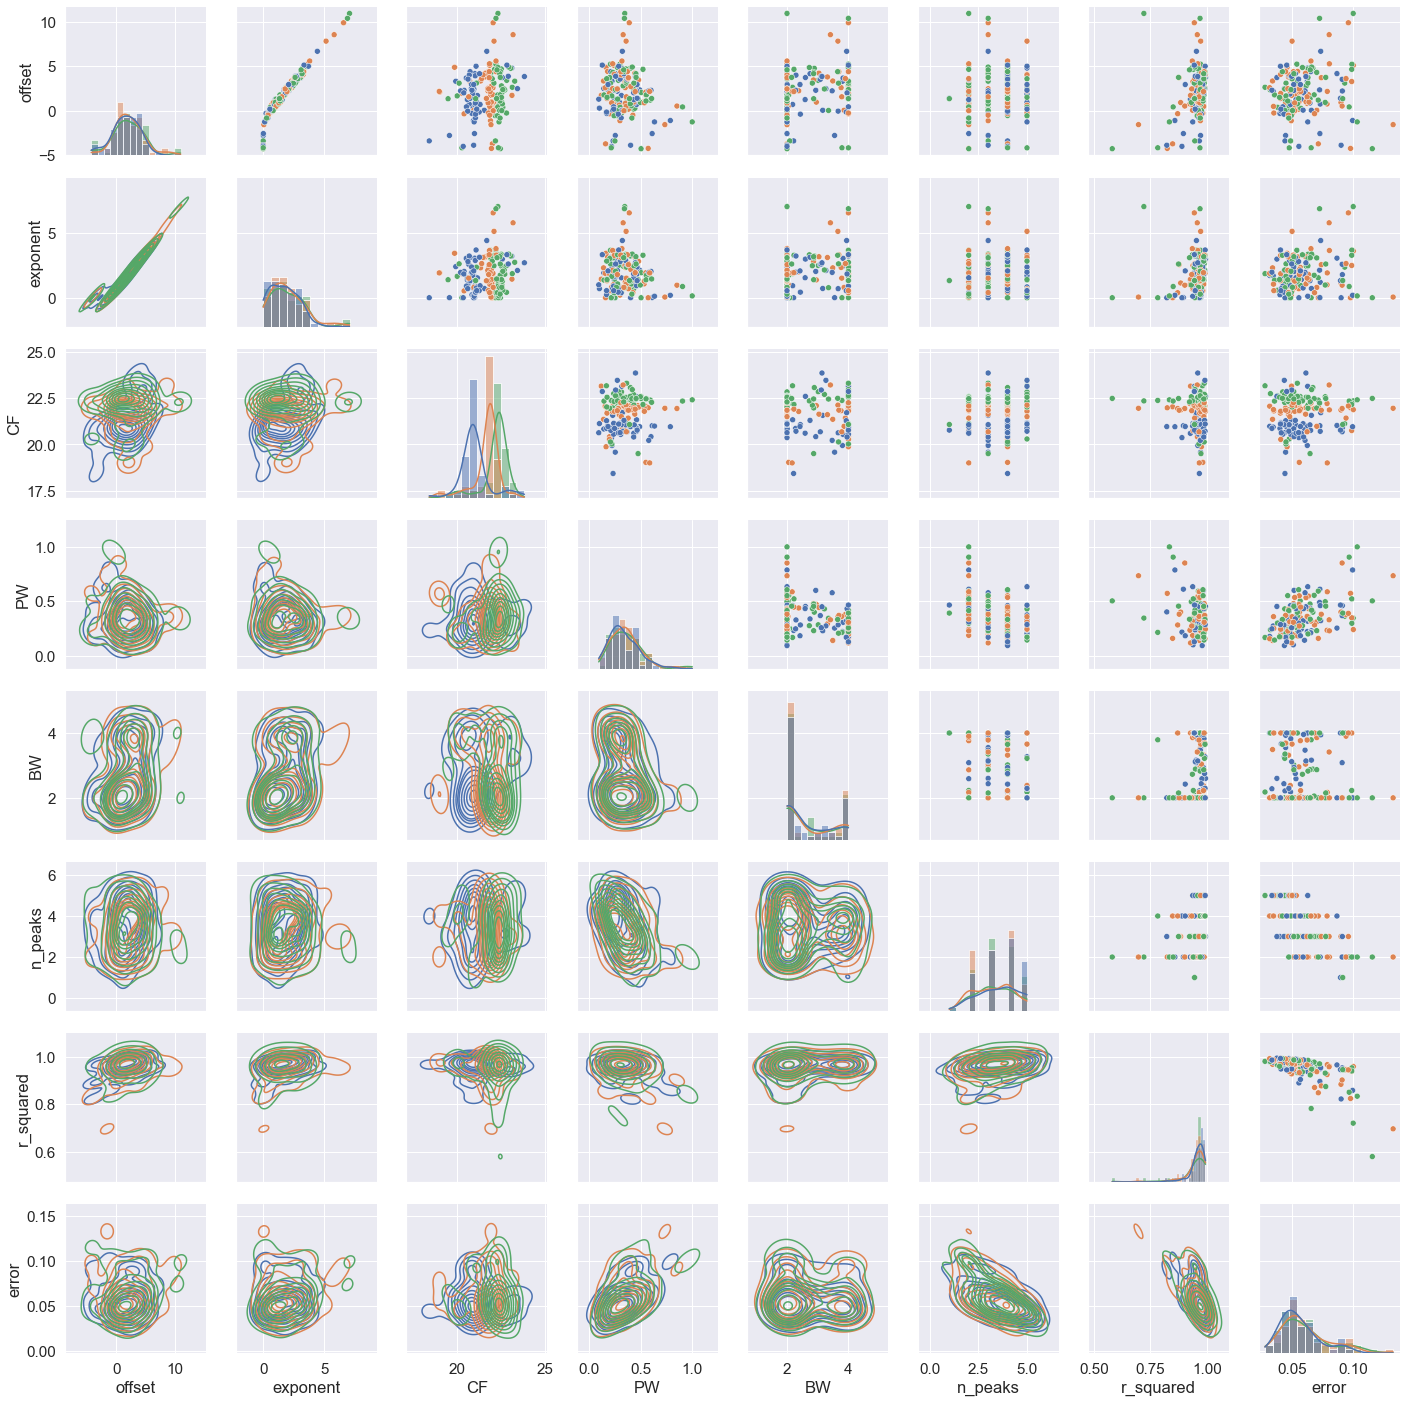

Done in 51.078s


In [44]:
tic = time.time()

g = sns.PairGrid(df_num)
g.map_upper(sns.scatterplot, hue=df['target'])
g.map_lower(sns.kdeplot, hue=df['target'], cmap = "Blues_d")
g.map_diag(sns.histplot, hue=df['target'], kde=True)
plt.show()

toc = time.time()
print(f"Done in {toc - tic:.3f}s")

## 4. Correlation matrix

,offset,knee,exponent,CF,PW,BW,n_peaks,r_squared,error
offset,1.00,0.29,0.97,0.20,-0.13,0.26,0.05,0.28,0.06
knee,0.29,1.00,0.32,0.06,-0.00,-0.05,-0.11,-0.33,0.18
exponent,0.97,0.32,1.00,0.19,-0.11,0.28,0.02,0.18,0.14
CF,0.20,0.06,0.19,1.00,0.06,-0.07,0.01,-0.12,0.03
PW,-0.13,-0.00,-0.11,0.06,1.00,-0.23,-0.40,-0.28,0.51
BW,0.26,-0.05,0.28,-0.07,-0.23,1.00,-0.02,0.14,-0.06
n_peaks,0.05,-0.11,0.02,0.01,-0.40,-0.02,1.00,0.30,-0.61
r_squared,0.28,-0.33,0.18,-0.12,-0.28,0.14,0.30,1.00,-0.65
error,0.06,0.18,0.14,0.03,0.51,-0.06,-0.61,-0.65,1.00


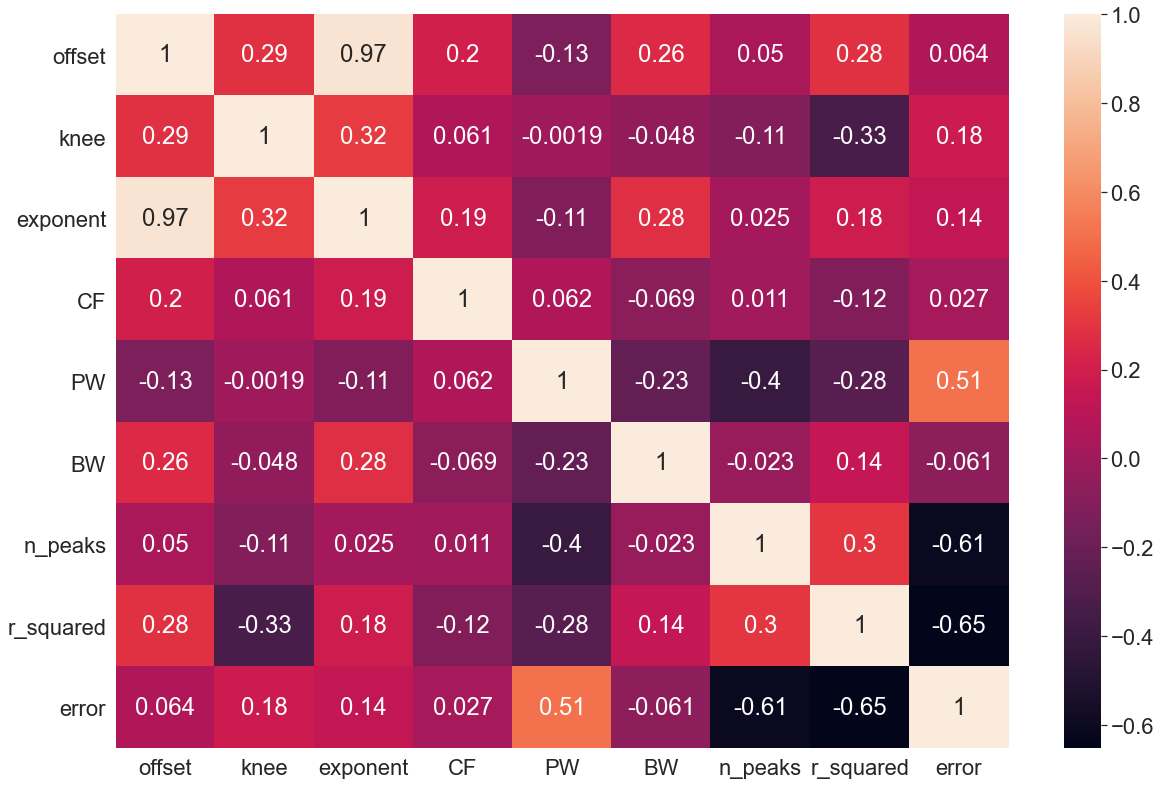

In [45]:
display(df.corr().round(2))

sns.set(font_scale = 2)
fig, heat = plt.subplots(figsize=(20,13.5))
heat = sns.heatmap(df.corr(), annot=True)
plt.show()

# IV. Classification
## Assign variables

In [46]:
# Number of observations
n_obs = len(df)

# Assign target and serie
y = df['target'].to_numpy().ravel()

# Select features
X = df.drop(columns=['subject', 'day', 'target']).to_numpy()

# Initialize dataframe
performance = pd.DataFrame([], index = [], columns = ['accuracy', 'precision', 'recall', 'classifier', 'n_channels', 'table'])

## 1. Logistic regression

C:\Users\ThinkPad\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:762: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Feature: 0, Score: 0.86761
Feature: 1, Score: -53.07346
Feature: 2, Score: -0.68403
Feature: 3, Score: -0.92038
Feature: 4, Score: 0.05195
Feature: 5, Score: -0.11274
Feature: 6, Score: 0.01769
Feature: 7, Score: -0.30995
Feature: 8, Score: -0.19112


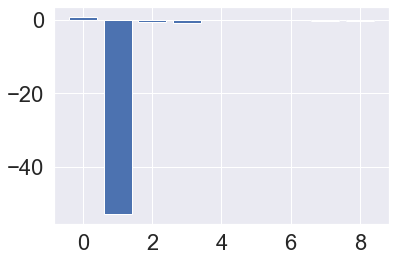

              precision    recall  f1-score   support

         210       0.92      0.79      0.85        14
         220       0.50      0.86      0.63         7
         225       0.92      0.73      0.81        15

    accuracy                           0.78        36
   macro avg       0.78      0.79      0.76        36
weighted avg       0.84      0.78      0.79        36

Feature: 0, Score: 0.41125
Feature: 1, Score: -32.12328
Feature: 2, Score: -0.22889
Feature: 3, Score: -1.13502
Feature: 4, Score: 0.11472
Feature: 5, Score: -0.05645
Feature: 6, Score: 0.20607
Feature: 7, Score: -0.07831
Feature: 8, Score: -0.15382


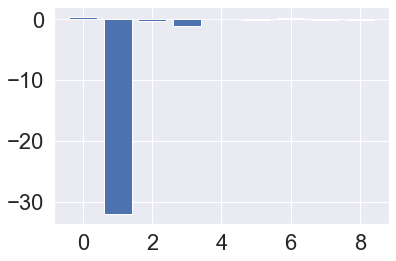

              precision    recall  f1-score   support

         210       0.75      0.60      0.67        15
         220       0.50      0.60      0.55        10
         225       0.64      0.70      0.67        10

    accuracy                           0.63        35
   macro avg       0.63      0.63      0.63        35
weighted avg       0.65      0.63      0.63        35

Feature: 0, Score: 0.83933
Feature: 1, Score: -60.98218
Feature: 2, Score: -0.80707
Feature: 3, Score: -1.04349
Feature: 4, Score: -0.12515
Feature: 5, Score: -0.20760
Feature: 6, Score: 0.07945
Feature: 7, Score: -0.07291
Feature: 8, Score: 0.01088


C:\Users\ThinkPad\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:762: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


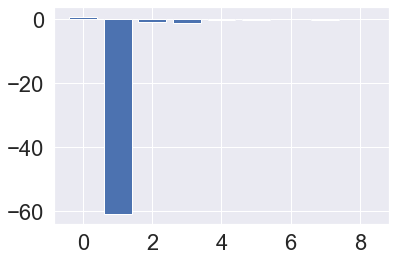

              precision    recall  f1-score   support

         210       0.58      0.70      0.64        10
         220       0.58      0.47      0.52        15
         225       0.55      0.60      0.57        10

    accuracy                           0.57        35
   macro avg       0.57      0.59      0.58        35
weighted avg       0.57      0.57      0.57        35

Feature: 0, Score: 0.57633
Feature: 1, Score: -574.02594
Feature: 2, Score: -0.32703
Feature: 3, Score: -1.01106
Feature: 4, Score: 0.03722
Feature: 5, Score: -0.06598
Feature: 6, Score: 0.02120
Feature: 7, Score: -0.55925
Feature: 8, Score: -0.65550


C:\Users\ThinkPad\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:762: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


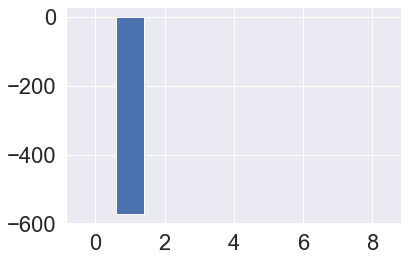

              precision    recall  f1-score   support

         210       0.50      0.50      0.50        12
         220       0.33      0.29      0.31        14
         225       0.45      0.56      0.50         9

    accuracy                           0.43        35
   macro avg       0.43      0.45      0.44        35
weighted avg       0.42      0.43      0.42        35

Feature: 0, Score: 0.88222
Feature: 1, Score: -9.29713
Feature: 2, Score: -0.62194
Feature: 3, Score: -1.03217
Feature: 4, Score: -0.09994
Feature: 5, Score: -0.23964
Feature: 6, Score: -0.04882
Feature: 7, Score: -0.29198
Feature: 8, Score: -0.33141


C:\Users\ThinkPad\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:762: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


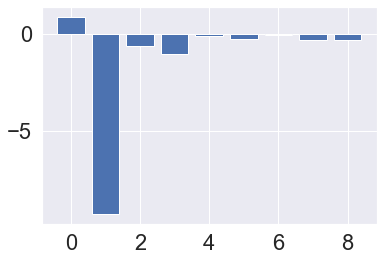

              precision    recall  f1-score   support

         210       0.64      0.78      0.70         9
         220       0.33      0.33      0.33        12
         225       0.50      0.43      0.46        14

    accuracy                           0.49        35
   macro avg       0.49      0.51      0.50        35
weighted avg       0.48      0.49      0.48        35



In [47]:
# Split in K folds and standardize
K = 5
cv = StratifiedKFold(n_splits=K, shuffle=True, random_state=13)
for train_index, test_index in cv.split(X, y):
    X_train, X_test = X[train_index], X[test_index]
    scaler = StandardScaler()
    X_train_scaled = scaler.fit_transform(X_train)
    X_test_scaled = scaler.transform(X_test)
    y_train, y_test = y[train_index], y[test_index]

    # Initialize model
    LR = LogisticRegression(penalty='none', random_state=13)

    # Fit model 
    LR.fit(X_train_scaled,y_train)

    # Predict output
    y_pred = LR.predict(X_test_scaled)
    
    # Summarize feature importance
    importance = LR.coef_[0]
    for i,v in enumerate(importance):
        print('Feature: %0d, Score: %.5f' % (i,v))
    plt.bar([x for x in range(len(importance))], importance)
    plt.show()

    # Output
    print(classification_report(y_pred, y_test))

    # Model performance
    accuracy = float(classification_report(y_pred, y_test)[-123:-119])
    precision = float(classification_report(y_pred, y_test)[-35:-31])
    recall = float(classification_report(y_pred, y_test)[-25:-21])
    
    # Save in dataframe
    row = pd.DataFrame([accuracy, precision, recall, 'log', n_channels, table], \
                   index = ['accuracy', 'precision', 'recall', 'classifier', 'n_channels', 'table']).transpose()
    performance = performance.append(row, ignore_index=True) 

In [48]:
# Variance inflation factors
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)
pd.DataFrame([variance_inflation_factor(X_scaled, i) for i in range(9)], 
             columns=['VIF'], \
             index = ['offset', 'knee', 'exponent', 'center of frequency', 'power', 'bandwidth', \
                      'n peaks', 'R2', 'MAE']).round(1)

,VIF
offset,19.0
knee,1.6
exponent,18.0
center of frequency,1.2
power,1.5
bandwidth,1.2
n peaks,1.8
R2,3.5
MAE,4.2


## 2. Ridge classifier

Feature: 0, Score: 0.01250
Feature: 1, Score: -0.02208
Feature: 2, Score: -0.03532
Feature: 3, Score: -0.30791
Feature: 4, Score: 0.00505
Feature: 5, Score: -0.01129
Feature: 6, Score: 0.02989
Feature: 7, Score: -0.01458
Feature: 8, Score: -0.01616


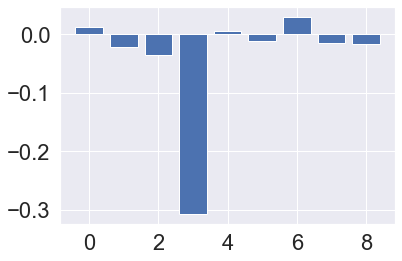

Alpha: 50.0
              precision    recall  f1-score   support

         210       0.92      0.85      0.88        13
         220       0.08      1.00      0.15         1
         225       1.00      0.55      0.71        22

    accuracy                           0.67        36
   macro avg       0.67      0.80      0.58        36
weighted avg       0.94      0.67      0.75        36

Feature: 0, Score: 0.00904
Feature: 1, Score: -0.03219
Feature: 2, Score: -0.01250
Feature: 3, Score: -0.34228
Feature: 4, Score: 0.01442
Feature: 5, Score: -0.00399
Feature: 6, Score: 0.07307
Feature: 7, Score: 0.03284
Feature: 8, Score: -0.02732


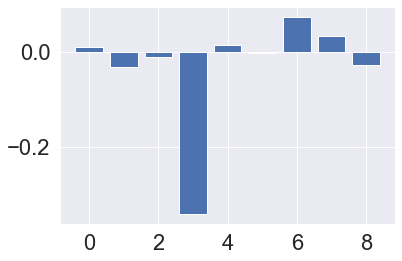

Alpha: 50.0
              precision    recall  f1-score   support

         210       1.00      0.67      0.80        18
         220       0.00      0.00      0.00         1
         225       0.64      0.44      0.52        16

    accuracy                           0.54        35
   macro avg       0.55      0.37      0.44        35
weighted avg       0.81      0.54      0.65        35

Feature: 0, Score: 0.24328
Feature: 1, Score: -0.02293
Feature: 2, Score: -0.24218
Feature: 3, Score: -0.46162
Feature: 4, Score: -0.06418
Feature: 5, Score: -0.06809
Feature: 6, Score: 0.04301
Feature: 7, Score: -0.02250
Feature: 8, Score: -0.00820


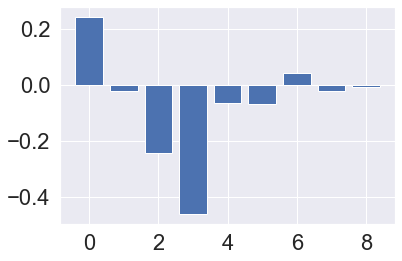

Alpha: 2.320794416806396
              precision    recall  f1-score   support

         210       0.67      0.62      0.64        13
         220       0.25      0.38      0.30         8
         225       0.64      0.50      0.56        14

    accuracy                           0.51        35
   macro avg       0.52      0.50      0.50        35
weighted avg       0.56      0.51      0.53        35

Feature: 0, Score: 0.00094
Feature: 1, Score: -0.01373
Feature: 2, Score: -0.02063
Feature: 3, Score: -0.31465
Feature: 4, Score: -0.02450
Feature: 5, Score: -0.00863
Feature: 6, Score: 0.06191
Feature: 7, Score: -0.03240
Feature: 8, Score: -0.09611


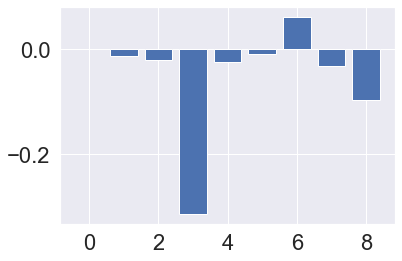

Alpha: 50.0
              precision    recall  f1-score   support

         210       0.50      0.50      0.50        12
         220       0.17      0.17      0.17        12
         225       0.55      0.55      0.55        11

    accuracy                           0.40        35
   macro avg       0.40      0.40      0.40        35
weighted avg       0.40      0.40      0.40        35

Feature: 0, Score: 0.01590
Feature: 1, Score: -0.01559
Feature: 2, Score: -0.02169
Feature: 3, Score: -0.32698
Feature: 4, Score: -0.03768
Feature: 5, Score: -0.05746
Feature: 6, Score: 0.02161
Feature: 7, Score: 0.01325
Feature: 8, Score: -0.05762


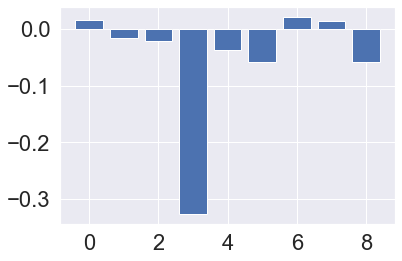

Alpha: 50.0
              precision    recall  f1-score   support

         210       0.82      0.82      0.82        11
         220       0.25      0.38      0.30         8
         225       0.58      0.44      0.50        16

    accuracy                           0.54        35
   macro avg       0.55      0.54      0.54        35
weighted avg       0.58      0.54      0.55        35



In [49]:
# Split in K folds and standardize
cv = StratifiedKFold(n_splits=K, shuffle=True, random_state=13)
for train_index, test_index in cv.split(X, y):
    X_train, X_test = X[train_index], X[test_index]
    scaler = StandardScaler()
    X_train_scaled = scaler.fit_transform(X_train)
    X_test_scaled = scaler.transform(X_test)
    y_train, y_test = y[train_index], y[test_index]
    
    # Optimize Ridge hyperparameter λ 
    hyperparameters = {"alpha": 10**np.linspace(10,-2,10)*0.5} 
    gkf=StratifiedKFold(n_splits=5, shuffle=True, random_state=13)
    Grid = GridSearchCV(RidgeClassifier(), hyperparameters, scoring='accuracy', cv=gkf, verbose=0, n_jobs=-1)
    Grid.fit(X_train_scaled, y_train)
    
    # Initialize model
    RC = RidgeClassifier(alpha=Grid.best_params_['alpha'], random_state=13)

    # Fit model 
    RC.fit(X_train_scaled,y_train)

    # Predict output
    y_pred = RC.predict(X_test_scaled)

    # Summarize feature importance
    importance = RC.coef_[0]
    for i,v in enumerate(importance):
        print('Feature: %0d, Score: %.5f' % (i,v))
    plt.bar([x for x in range(len(importance))], importance)
    plt.show()
    
    # Output
    print("Alpha:",Grid.best_params_['alpha'])
    print(classification_report(y_pred, y_test))
    
    # Model performance
    accuracy = float(classification_report(y_pred, y_test)[-123:-119])
    precision = float(classification_report(y_pred, y_test)[-35:-31])
    recall = float(classification_report(y_pred, y_test)[-25:-21])
         
    # Save in dataframe
    row = pd.DataFrame([accuracy, precision, recall, 'ridge', n_channels, table], \
                   index = ['accuracy', 'precision', 'recall', 'classifier', 'n_channels', 'table']).transpose()
    performance = performance.append(row, ignore_index=True)   

## 3. K-nearest neighbors

Feature: 0, Score: -0.02778
Feature: 1, Score: 0.02222
Feature: 2, Score: -0.04444
Feature: 3, Score: -0.02222
Feature: 4, Score: 0.00000
Feature: 5, Score: -0.02778
Feature: 6, Score: 0.02222
Feature: 7, Score: 0.00000
Feature: 8, Score: 0.00000


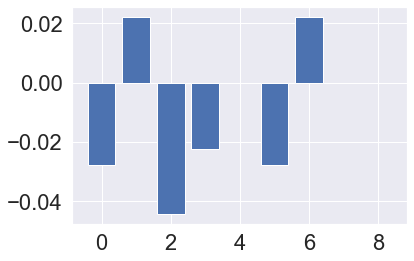

n_neighbors: 10
              precision    recall  f1-score   support

         210       0.92      0.79      0.85        14
         220       0.42      0.45      0.43        11
         225       0.50      0.55      0.52        11

    accuracy                           0.61        36
   macro avg       0.61      0.60      0.60        36
weighted avg       0.64      0.61      0.62        36

Feature: 0, Score: -0.02286
Feature: 1, Score: -0.00571
Feature: 2, Score: -0.02286
Feature: 3, Score: -0.02857
Feature: 4, Score: -0.01714
Feature: 5, Score: -0.01714
Feature: 6, Score: -0.03429
Feature: 7, Score: -0.01143
Feature: 8, Score: 0.00000


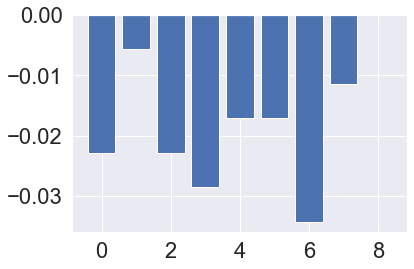

n_neighbors: 7
              precision    recall  f1-score   support

         210       0.83      0.67      0.74        15
         220       0.58      0.58      0.58        12
         225       0.45      0.62      0.53         8

    accuracy                           0.63        35
   macro avg       0.62      0.62      0.62        35
weighted avg       0.66      0.63      0.64        35

Feature: 0, Score: -0.01714
Feature: 1, Score: -0.07429
Feature: 2, Score: -0.02286
Feature: 3, Score: -0.01714
Feature: 4, Score: -0.01143
Feature: 5, Score: -0.01143
Feature: 6, Score: -0.01143
Feature: 7, Score: 0.00000
Feature: 8, Score: 0.00000


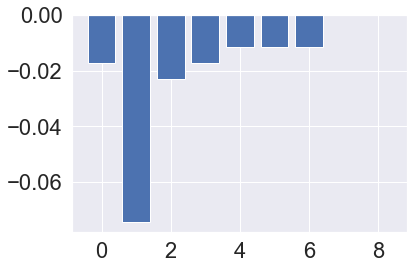

n_neighbors: 5
              precision    recall  f1-score   support

         210       0.67      0.62      0.64        13
         220       0.58      0.70      0.64        10
         225       0.64      0.58      0.61        12

    accuracy                           0.63        35
   macro avg       0.63      0.63      0.63        35
weighted avg       0.63      0.63      0.63        35

Feature: 0, Score: 0.00000
Feature: 1, Score: 0.00571
Feature: 2, Score: 0.00000
Feature: 3, Score: 0.00000
Feature: 4, Score: 0.00000
Feature: 5, Score: 0.00000
Feature: 6, Score: -0.01714
Feature: 7, Score: 0.00000
Feature: 8, Score: 0.00000


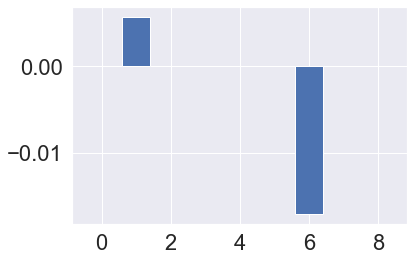

n_neighbors: 4
              precision    recall  f1-score   support

         210       0.67      0.67      0.67        12
         220       0.75      0.50      0.60        18
         225       0.45      1.00      0.62         5

    accuracy                           0.63        35
   macro avg       0.62      0.72      0.63        35
weighted avg       0.68      0.63      0.63        35

Feature: 0, Score: 0.00000
Feature: 1, Score: 0.00000
Feature: 2, Score: 0.00000
Feature: 3, Score: 0.00000
Feature: 4, Score: 0.00000
Feature: 5, Score: 0.00000
Feature: 6, Score: 0.00000
Feature: 7, Score: 0.00000
Feature: 8, Score: 0.00000


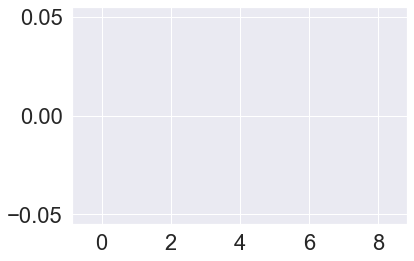

n_neighbors: 15
              precision    recall  f1-score   support

         210       0.55      0.60      0.57        10
         220       0.42      0.31      0.36        16
         225       0.42      0.56      0.48         9

    accuracy                           0.46        35
   macro avg       0.46      0.49      0.47        35
weighted avg       0.45      0.46      0.45        35



In [50]:
# Split in K folds and standardize
cv = StratifiedKFold(n_splits=K, shuffle=True, random_state=13)
for train_index, test_index in cv.split(X, y):
    X_train, X_test = X[train_index], X[test_index]
    scaler = StandardScaler()
    X_train_scaled = scaler.fit_transform(X_train)
    X_test_scaled = scaler.transform(X_test)
    y_train, y_test = y[train_index], y[test_index]
    
    # Optimize hyperparameter K
    hyperparameters = {'n_neighbors':[i for i in range(1,20)]}
    gkf=StratifiedKFold(n_splits=5, shuffle=True, random_state=13)
    Grid = GridSearchCV(KNeighborsClassifier(), hyperparameters, scoring='accuracy', cv=gkf, verbose=0, n_jobs=-1)
    Grid.fit(X_train_scaled, y_train)
        
    # Initialize model
    KNN = KNeighborsClassifier(n_neighbors=Grid.best_params_['n_neighbors'])
    
    # Fit model 
    KNN.fit(X_train_scaled,y_train)

    # Predict output
    y_pred = KNN.predict(X_test_scaled)
    
    # Summarize feature importance
    results = permutation_importance(KNN, X_test, y_test, scoring='accuracy')
    importance = results.importances_mean
    for i,v in enumerate(importance):
        print('Feature: %0d, Score: %.5f' % (i,v))
    plt.bar([x for x in range(len(importance))], importance)
    plt.show()
    
    # Output
    print('n_neighbors:',Grid.best_params_['n_neighbors'])
    print(classification_report(y_pred, y_test))
    
    # Model performance
    accuracy = float(classification_report(y_pred, y_test)[-123:-119])
    precision = float(classification_report(y_pred, y_test)[-35:-31])
    recall = float(classification_report(y_pred, y_test)[-25:-21])
        
    # Save in dataframe
    row = pd.DataFrame([accuracy, precision, recall, 'KNN', n_channels, table], \
                   index = ['accuracy', 'precision', 'recall', 'classifier', 'n_channels', 'table']).transpose()
    performance = performance.append(row, ignore_index=True)   

## 4. Multi-layer perceptron

In [51]:
# Split in K folds and standardize
cv = StratifiedKFold(n_splits=K, shuffle=True, random_state=13)
for train_index, test_index in cv.split(X, y):
    X_train, X_test = X[train_index], X[test_index]
    scaler = StandardScaler()
    X_train_scaled = scaler.fit_transform(X_train)
    X_test_scaled = scaler.transform(X_test)
    y_train, y_test = y[train_index], y[test_index]

    # Optimize hyperparameters
    hyperparameters = {'activation':['identity', 'logistic', 'tanh', 'relu'], 'solver':['lbfgs', 'sgd', 'adam']}
    gkf=StratifiedKFold(n_splits=5, shuffle=True, random_state=13)
    Grid = GridSearchCV(MLPClassifier(), hyperparameters, scoring='accuracy', cv=gkf, verbose=0, n_jobs=-1)
    Grid.fit(X_train_scaled, y_train)
    
    # Initialize model
    MLP = MLPClassifier(hidden_layer_sizes=(150,100,50), max_iter=500, activation = Grid.best_params_['activation'], \
                        solver=Grid.best_params_['solver'], random_state=13)

    # Fit model 
    MLP.fit(X_train_scaled,y_train)

    # Predict output
    y_pred = MLP.predict(X_test_scaled)

    # Output
    print(f"\033[1mActivation function: \033[0m{Grid.best_params_['activation']}")
    print(f"\033[1mSolver: \033[0m{Grid.best_params_['solver']}")
    print(classification_report(y_pred, y_test))
    
    # Model performance
    accuracy = float(classification_report(y_pred, y_test)[-123:-119])
    precision = float(classification_report(y_pred, y_test)[-35:-31])
    recall = float(classification_report(y_pred, y_test)[-25:-21])
     
    # Save in dataframe
    row = pd.DataFrame([accuracy, precision, recall, 'MLP', n_channels, table], \
                   index = ['accuracy', 'precision', 'recall', 'classifier', 'n_channels', 'table']).transpose()
    performance = performance.append(row, ignore_index=True)   

Activation function: logistic
Solver: lbfgs
              precision    recall  f1-score   support

         210       0.92      0.79      0.85        14
         220       0.58      0.88      0.70         8
         225       0.75      0.64      0.69        14

    accuracy                           0.75        36
   macro avg       0.75      0.77      0.75        36
weighted avg       0.78      0.75      0.75        36

Activation function: logistic
Solver: lbfgs
              precision    recall  f1-score   support

         210       0.83      0.77      0.80        13
         220       0.67      0.67      0.67        12
         225       0.73      0.80      0.76        10

    accuracy                           0.74        35
   macro avg       0.74      0.75      0.74        35
weighted avg       0.75      0.74      0.74        35

Activation function: logistic
Solver: lbfgs
              precision    recall  f1-score   support

         210       0.75      0.82      0.78        

## 5. Random forest

Feature: 0, Score: 0.07556
Feature: 1, Score: 0.07713
Feature: 2, Score: 0.07176
Feature: 3, Score: 0.47395
Feature: 4, Score: 0.08089
Feature: 5, Score: 0.06092
Feature: 6, Score: 0.02245
Feature: 7, Score: 0.05944
Feature: 8, Score: 0.07790


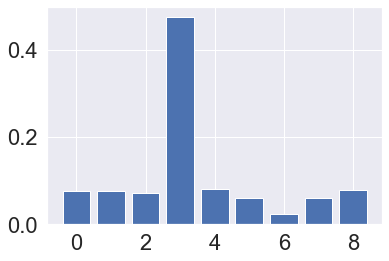

Number of trees: 200
Maximum depth: 10
Maximum features per node split: auto
              precision    recall  f1-score   support

         210       0.92      0.85      0.88        13
         220       0.67      1.00      0.80         8
         225       1.00      0.80      0.89        15

    accuracy                           0.86        36
   macro avg       0.86      0.88      0.86        36
weighted avg       0.90      0.86      0.87        36

Feature: 0, Score: 0.05759
Feature: 1, Score: 0.06413
Feature: 2, Score: 0.05682
Feature: 3, Score: 0.52485
Feature: 4, Score: 0.07419
Feature: 5, Score: 0.05299
Feature: 6, Score: 0.02098
Feature: 7, Score: 0.08212
Feature: 8, Score: 0.06634


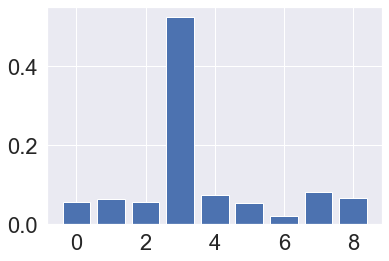

Number of trees: 1000
Maximum depth: 55
Maximum features per node split: sqrt
              precision    recall  f1-score   support

         210       0.92      0.73      0.81        15
         220       0.67      0.80      0.73        10
         225       0.64      0.70      0.67        10

    accuracy                           0.74        35
   macro avg       0.74      0.74      0.74        35
weighted avg       0.77      0.74      0.75        35

Feature: 0, Score: 0.06102
Feature: 1, Score: 0.07281
Feature: 2, Score: 0.06278
Feature: 3, Score: 0.52291
Feature: 4, Score: 0.07465
Feature: 5, Score: 0.04764
Feature: 6, Score: 0.02062
Feature: 7, Score: 0.07053
Feature: 8, Score: 0.06704


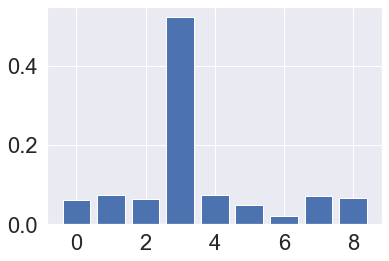

Number of trees: 200
Maximum depth: 100
Maximum features per node split: sqrt
              precision    recall  f1-score   support

         210       0.75      0.75      0.75        12
         220       0.67      1.00      0.80         8
         225       0.91      0.67      0.77        15

    accuracy                           0.77        35
   macro avg       0.78      0.81      0.77        35
weighted avg       0.80      0.77      0.77        35

Feature: 0, Score: 0.06616
Feature: 1, Score: 0.07807
Feature: 2, Score: 0.06808
Feature: 3, Score: 0.49671
Feature: 4, Score: 0.06356
Feature: 5, Score: 0.05391
Feature: 6, Score: 0.02213
Feature: 7, Score: 0.07624
Feature: 8, Score: 0.07514


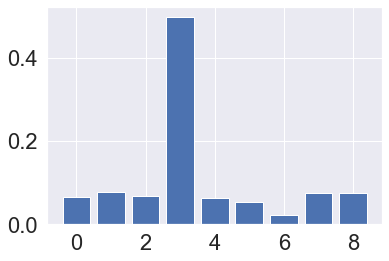

Number of trees: 200
Maximum depth: 55
Maximum features per node split: auto
              precision    recall  f1-score   support

         210       0.75      0.69      0.72        13
         220       0.83      0.62      0.71        16
         225       0.55      1.00      0.71         6

    accuracy                           0.71        35
   macro avg       0.71      0.77      0.71        35
weighted avg       0.75      0.71      0.71        35

Feature: 0, Score: 0.06127
Feature: 1, Score: 0.07427
Feature: 2, Score: 0.06344
Feature: 3, Score: 0.48417
Feature: 4, Score: 0.08319
Feature: 5, Score: 0.05837
Feature: 6, Score: 0.02275
Feature: 7, Score: 0.07092
Feature: 8, Score: 0.08162


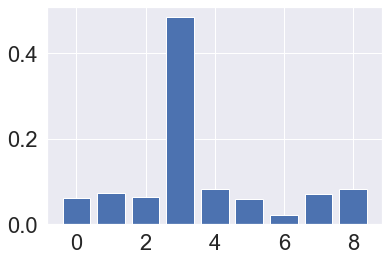

Number of trees: 200
Maximum depth: 10
Maximum features per node split: auto
              precision    recall  f1-score   support

         210       0.82      0.90      0.86        10
         220       0.92      0.69      0.79        16
         225       0.67      0.89      0.76         9

    accuracy                           0.80        35
   macro avg       0.80      0.83      0.80        35
weighted avg       0.82      0.80      0.80        35

Done in 696.4738657474518 seconds


In [52]:
tic = time.time()

# Split in K folds
cv = StratifiedKFold(n_splits=K, shuffle=True, random_state=13)
for train_index, test_index in cv.split(X, y):
    X_train, X_test = X[train_index], X[test_index]
    y_train, y_test = y[train_index], y[test_index]
        
    # Optimize hyperparameters
    hyperparameters = {"n_estimators": [200, 1000, 2000], \
                       "max_depth": [int(x) for x in np.linspace(10, 100, num = 5)],\
                       "max_features": ['auto', 'sqrt']}
    gkf=StratifiedKFold(n_splits=5, shuffle=True, random_state=13)
    Grid = GridSearchCV(RandomForestClassifier(), hyperparameters, scoring='accuracy', cv=gkf, verbose=0, n_jobs=-1)
    Grid.fit(X_train, y_train)
    
    # Initiating a RF classifier
    RFC = RandomForestClassifier(n_estimators = Grid.best_params_['n_estimators'], \
                                max_depth = Grid.best_params_['max_depth'], \
                                max_features = Grid.best_params_['max_features'], random_state = 13)  

    # Fit model
    RFC.fit(X_train, y_train)
  
    # performing predictions on the test dataset
    y_pred = RFC.predict(X_test)
    
    # Summarize feature importance
    importance = RFC.feature_importances_
    for i,v in enumerate(importance):
        print('Feature: %0d, Score: %.5f' % (i,v))
    plt.bar([x for x in range(len(importance))], importance)
    plt.show()

    # Output
    print(f"\033[1mNumber of trees: \033[0m{Grid.best_params_['n_estimators']}")
    print(f"\033[1mMaximum depth: \033[0m{Grid.best_params_['max_depth']}")
    print(f"\033[1mMaximum features per node split: \033[0m{Grid.best_params_['max_features']}")
    print(classification_report(y_pred, y_test))
    
    # Model performance
    accuracy = float(classification_report(y_pred, y_test)[-123:-119])
    precision = float(classification_report(y_pred, y_test)[-35:-31])
    recall = float(classification_report(y_pred, y_test)[-25:-21])
        
    # Save in dataframe
    row = pd.DataFrame([accuracy, precision, recall, 'RF',  n_channels, table], \
                   index = ['accuracy', 'precision', 'recall', 'classifier', 'n_channels', 'table']).transpose()
    performance = performance.append(row, ignore_index=True)    

print(f'Done in {time.time()-tic} seconds')

# Same for 3 channels
# I. Preparation

In [53]:
# Occipital channels
channels = (23,24,25) 
n_channels = 3

# II. Fourier transform and FOOOF

In [54]:
## Read EEG, calculate PSD (Welch), fit FOOOF

tic = time.time()
for subject in subjects: 
    for day in days:
        # Initialize per target, average over trials and channels
        powers_50 = np.empty((0, int(nperseg//2)+1), float)
        powers_55 = np.empty((0, int(nperseg//2)+1), float)
        powers_60 = np.empty((0, int(nperseg//2)+1), float)
        powers_65 = np.empty((0, int(nperseg//2)+1), float)
        powers_210 = np.empty((0, int(nperseg//2)+1), float)
        powers_215 = np.empty((0, int(nperseg//2)+1), float)
        powers_220 = np.empty((0, int(nperseg//2)+1), float)
        powers_225 = np.empty((0, int(nperseg//2)+1), float)
        powers_400 = np.empty((0, int(nperseg//2)+1), float)
        powers_405 = np.empty((0, int(nperseg//2)+1), float)
        powers_410 = np.empty((0, int(nperseg//2)+1), float)
        powers_415 = np.empty((0, int(nperseg//2)+1), float)

        # Change working directory
        original = os.getcwd()
        os.chdir("C:/Users/ThinkPad/Desktop/Thesis/Data/"+subject+day)

        # Giving directory name
        folderdir = 'C:/Users/ThinkPad/Desktop/Thesis/Data/'+subject+day

        # Giving file extensions
        ext = ('.mat')

        # Iterating over directory
        for path, dirc, files in os.walk(folderdir):
            for file in files:
                if file.endswith(ext) and file.startswith('cnt'):
                    print(subject, day, file)

                    # LOW, MID, or HIGH
                    level = file[4:-7]

                    # Session 1, or session 2
                    session = file[-6]

                    # Read data
                    data = read_matlab(file)['cnt']['x']

                    # Read timestamps 
                    timestamps = (read_matlab(folderdir+'/mrk_'+level+'('+session+').mat')['mrk']['time'])[0]

                    # Read stimuli order
                    order_stimuli = read_matlab(folderdir+'/mrk_'+level+'('+session+').mat')['mrk']['event']['desc']

                    for trial, timestamp in enumerate(timestamps):   
                        if trial%2 == False:
                            start = int(timestamp)
                        else:
                            stop = int(timestamp)

                            for channel in channels:
#                                 # Apply bandpass filter
#                                 data[:,channel] = filter_signal(data[:,channel], fs, 'bandpass', f_range=fr)

                                # Splice data according to timestamps
                                sig = data[:,channel][start:stop]
                                times = create_times(len(sig)/fs, fs)

#                                 # Plot EEG 
#                                 fig, ax = plt.subplots(figsize=[15, 5])
#                                 plot_time_series(times, sig, xlim=[0,len(sig)/fs], ax=ax)
#                                 plt.show()                                

                                # Welch FFT: calculate mean of spectrogram
                                freq, power = signal.welch(sig, fs, window='hann', average='mean', nperseg=nperseg,\
                                                          noverlap=450, detrend='constant')

                                # Append power to previous powers
                                if level=='LOW':
                                    if order_stimuli[trial-1]==[1.]: 
                                        powers_50 = np.append(powers_50, power.reshape(1, len(freq)), axis=0)
                                    elif order_stimuli[trial-1]==[2.]: 
                                        powers_55 = np.append(powers_55, power.reshape(1, len(freq)), axis=0)
                                    elif order_stimuli[trial-1]==[3.]: 
                                        powers_60 = np.append(powers_60, power.reshape(1, len(freq)), axis=0)
                                    elif order_stimuli[trial-1]==[4.]: 
                                        powers_65 = np.append(powers_65, power.reshape(1, len(freq)), axis=0)
                                elif level=='MID':
                                    if order_stimuli[trial-1]==[1.]: 
                                        powers_210 = np.append(powers_210, power.reshape(1, len(freq)), axis=0)
                                    elif order_stimuli[trial-1]==[2.]: 
                                        powers_215 = np.append(powers_215, power.reshape(1, len(freq)), axis=0)
                                    elif order_stimuli[trial-1]==[3.]: 
                                        powers_220 = np.append(powers_220, power.reshape(1, len(freq)), axis=0)
                                    elif order_stimuli[trial-1]==[4.]: 
                                        powers_225 = np.append(powers_225, power.reshape(1, len(freq)), axis=0)
                                elif level=='HIGH':
                                    if order_stimuli[trial-1]==[1.]: 
                                        powers_400 = np.append(powers_400, power.reshape(1, len(freq)), axis=0)
                                    elif order_stimuli[trial-1]==[2.]: 
                                        powers_405 = np.append(powers_405, power.reshape(1, len(freq)), axis=0)
                                    elif order_stimuli[trial-1]==[3.]: 
                                        powers_410 = np.append(powers_410, power.reshape(1, len(freq)), axis=0)
                                    elif order_stimuli[trial-1]==[4.]: 
                                        powers_415 = np.append(powers_415, power.reshape(1, len(freq)), axis=0)

        # Fit FOOOF model per target
        for (powers, target) in zip((powers_210, powers_220, powers_225), \
                                    (210, 220, 225)):
            # FOOOF object: initialize, fit and print results
            fm = FOOOF(aperiodic_mode='knee', peak_width_limits=pwl, max_n_peaks=mnp, peak_threshold=pt, verbose=True)
            fm.fit(freq, np.mean(powers, axis=0), freq_range=fr)
            fm.print_results()
#             fig, ax = plt.subplots(figsize=[15, 5])
#             fm.plot(plot_peaks='line-shade', ax=ax)
#             plt.show()

            # Save metadata, FOOOF parameters and results
            try:
                if np.isnan(get_band_peak_fm(fm, band=bn, select_highest=True)[0])==False:
                    row = pd.DataFrame([subject, day, target, \
                                        fm.aperiodic_params_[0], \
                                        fm.aperiodic_params_[1], \
                                        fm.aperiodic_params_[2], \
                                        get_band_peak_fm(fm, band=bn, select_highest=True)[0], \
                                        get_band_peak_fm(fm, band=bn, select_highest=True)[1], \
                                        get_band_peak_fm(fm, band=bn, select_highest=True)[2], \
                                        fm.n_peaks_,\
                                        fm.r_squared_, \
                                        fm.error_],
                                       index = ['subject', 'day', 'target', \
                                                'offset', 'knee', 'exponent',\
                                                'CF', 'PW', 'BW', 'n_peaks', \
                                                'r_squared', 'error']).transpose()
                    df = df.append(row, ignore_index=True) 
            except:
                pass

# Typecast dataframe
df[['subject', 'day', 'target']] = df[['subject', 'day', 'target']].astype('category')
df['n_peaks'] = df['n_peaks'].astype('int32')
df[['offset', 'knee', 'exponent', 'CF', 'PW', 'BW', 'r_squared', 'error']] = \
df[['offset', 'knee', 'exponent', 'CF', 'PW', 'BW', 'r_squared', 'error']].astype('float32')

# Change working directory back
os.chdir(original)

print(f'Done in {time.time()-tic} seconds')

S1 /Day1 cnt_HIGH(1).mat
S1 /Day1 cnt_HIGH(2).mat
S1 /Day1 cnt_LOW(1).mat
S1 /Day1 cnt_LOW(2).mat
S1 /Day1 cnt_MID(1).mat
S1 /Day1 cnt_MID(2).mat
                                                                                                  
                                   FOOOF - POWER SPECTRUM MODEL                                   
                                                                                                  
                       The model was run on the frequency range 10 - 50 Hz                        
                                 Frequency Resolution is 0.40 Hz                                  
                                                                                                  
                         Aperiodic Parameters (offset, knee, exponent):                           
                                     -3.4291, -1.0021, 0.0009                                     
                                                              

# IV. Classification
## Assign variables

In [55]:
# Number of observations
n_obs = len(df)

# Assign target and serie
y = df['target'].to_numpy().ravel()

# Select features
X = df.drop(columns=['subject', 'day', 'target']).to_numpy()

## 1. Logistic regression

Feature: 0, Score: 0.31600
Feature: 1, Score: -3.28454
Feature: 2, Score: -0.03346
Feature: 3, Score: -1.13582
Feature: 4, Score: 0.10787
Feature: 5, Score: -0.15679
Feature: 6, Score: -0.08141
Feature: 7, Score: -0.24825
Feature: 8, Score: -0.41379


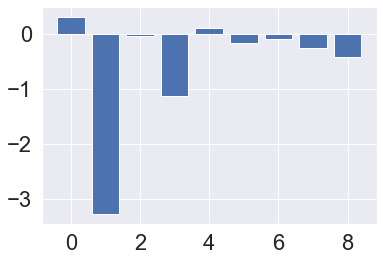

              precision    recall  f1-score   support

         210       0.88      0.81      0.84        26
         220       0.50      0.52      0.51        23
         225       0.57      0.59      0.58        22

    accuracy                           0.65        71
   macro avg       0.65      0.64      0.64        71
weighted avg       0.66      0.65      0.65        71

Feature: 0, Score: 0.06399
Feature: 1, Score: -1.11908
Feature: 2, Score: -0.04571
Feature: 3, Score: -1.17501
Feature: 4, Score: 0.08966
Feature: 5, Score: -0.23406
Feature: 6, Score: 0.05835
Feature: 7, Score: -0.04632
Feature: 8, Score: -0.14228


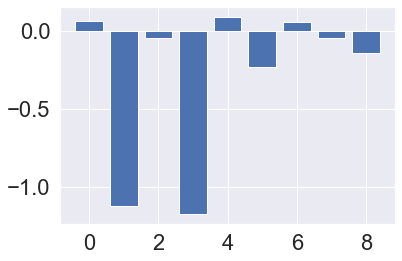

              precision    recall  f1-score   support

         210       0.79      0.86      0.83        22
         220       0.62      0.71      0.67        21
         225       0.78      0.64      0.71        28

    accuracy                           0.73        71
   macro avg       0.73      0.74      0.73        71
weighted avg       0.74      0.73      0.73        71

Feature: 0, Score: 0.52449
Feature: 1, Score: -0.73006
Feature: 2, Score: -0.35840
Feature: 3, Score: -1.07677
Feature: 4, Score: 0.01098
Feature: 5, Score: -0.06296
Feature: 6, Score: -0.06405
Feature: 7, Score: -0.13353
Feature: 8, Score: -0.20916


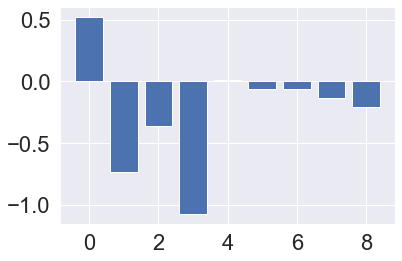

              precision    recall  f1-score   support

         210       0.88      0.81      0.84        26
         220       0.42      0.67      0.51        15
         225       0.86      0.66      0.75        29

    accuracy                           0.71        70
   macro avg       0.72      0.71      0.70        70
weighted avg       0.77      0.71      0.73        70

Feature: 0, Score: 0.33041
Feature: 1, Score: -282.12718
Feature: 2, Score: -0.27721
Feature: 3, Score: -1.14027
Feature: 4, Score: 0.07711
Feature: 5, Score: -0.14547
Feature: 6, Score: -0.13183
Feature: 7, Score: -0.12759
Feature: 8, Score: -0.35894


C:\Users\ThinkPad\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:762: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


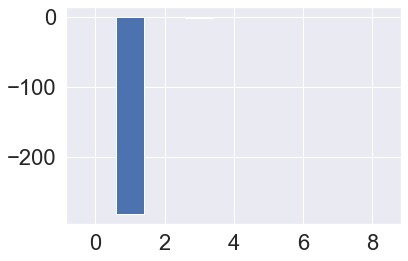

              precision    recall  f1-score   support

         210       0.87      0.74      0.80        27
         220       0.46      0.73      0.56        15
         225       0.83      0.68      0.75        28

    accuracy                           0.71        70
   macro avg       0.72      0.72      0.70        70
weighted avg       0.76      0.71      0.73        70

Feature: 0, Score: 0.19828
Feature: 1, Score: -0.79967
Feature: 2, Score: -0.06279
Feature: 3, Score: -1.46257
Feature: 4, Score: 0.14956
Feature: 5, Score: -0.19209
Feature: 6, Score: -0.10446
Feature: 7, Score: -0.19680
Feature: 8, Score: -0.47977


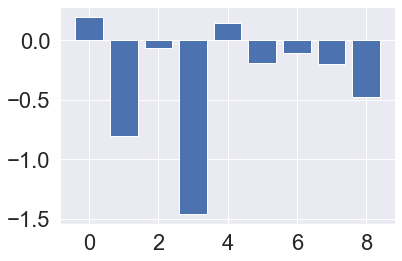

              precision    recall  f1-score   support

         210       0.83      0.76      0.79        25
         220       0.54      0.87      0.67        15
         225       0.83      0.63      0.72        30

    accuracy                           0.73        70
   macro avg       0.73      0.75      0.73        70
weighted avg       0.77      0.73      0.73        70



In [56]:
# Split in K folds and standardize
K = 5
cv = StratifiedKFold(n_splits=K, shuffle=True, random_state=13)
for train_index, test_index in cv.split(X, y):
    X_train, X_test = X[train_index], X[test_index]
    scaler = StandardScaler()
    X_train_scaled = scaler.fit_transform(X_train)
    X_test_scaled = scaler.transform(X_test)
    y_train, y_test = y[train_index], y[test_index]

    # Initialize model
    LR = LogisticRegression(penalty='none', random_state=13)

    # Fit model 
    LR.fit(X_train_scaled,y_train)

    # Predict output
    y_pred = LR.predict(X_test_scaled)
    
    # Summarize feature importance
    importance = LR.coef_[0]
    for i,v in enumerate(importance):
        print('Feature: %0d, Score: %.5f' % (i,v))
    plt.bar([x for x in range(len(importance))], importance)
    plt.show()

    # Output
    print(classification_report(y_pred, y_test))

    # Model performance
    accuracy = float(classification_report(y_pred, y_test)[-123:-119])
    precision = float(classification_report(y_pred, y_test)[-35:-31])
    recall = float(classification_report(y_pred, y_test)[-25:-21])
    
    # Save in dataframe
    row = pd.DataFrame([accuracy, precision, recall, 'log', n_channels, table], \
                   index = ['accuracy', 'precision', 'recall', 'classifier', 'n_channels', 'table']).transpose()
    performance = performance.append(row, ignore_index=True) 

In [57]:
# Variance inflation factors
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)
pd.DataFrame([variance_inflation_factor(X_scaled, i) for i in range(9)], 
             columns=['VIF'], \
             index = ['offset', 'knee', 'exponent', 'center of frequency', 'power', 'bandwidth', \
                      'n peaks', 'R2', 'MAE']).round(1)

,VIF
offset,14.3
knee,1.3
exponent,14.4
center of frequency,1.2
power,1.8
bandwidth,1.2
n peaks,1.6
R2,2.5
MAE,3.4


## 2. Ridge classifier

Feature: 0, Score: -0.00811
Feature: 1, Score: -0.00826
Feature: 2, Score: -0.01027
Feature: 3, Score: -0.09684
Feature: 4, Score: -0.01396
Feature: 5, Score: -0.00022
Feature: 6, Score: 0.00937
Feature: 7, Score: 0.01313
Feature: 8, Score: -0.01762


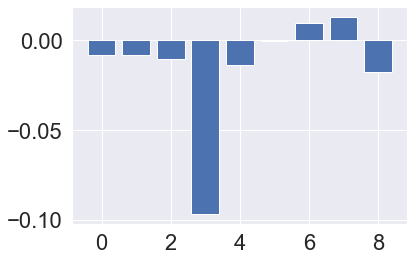

Alpha: 1077.2173450159432
              precision    recall  f1-score   support

         210       0.92      0.71      0.80        31
         220       0.25      0.40      0.31        15
         225       0.52      0.48      0.50        25

    accuracy                           0.56        71
   macro avg       0.56      0.53      0.54        71
weighted avg       0.64      0.56      0.59        71

Feature: 0, Score: -0.01854
Feature: 1, Score: -0.00655
Feature: 2, Score: -0.01830
Feature: 3, Score: -0.10088
Feature: 4, Score: -0.00162
Feature: 5, Score: -0.00658
Feature: 6, Score: 0.01338
Feature: 7, Score: 0.01442
Feature: 8, Score: -0.00987


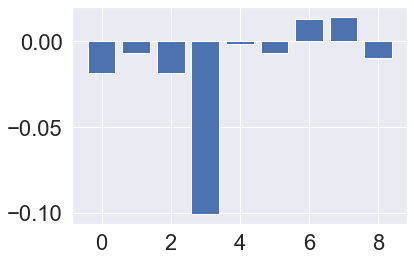

Alpha: 1077.2173450159432
              precision    recall  f1-score   support

         210       0.83      0.74      0.78        27
         220       0.58      0.78      0.67        18
         225       0.83      0.73      0.78        26

    accuracy                           0.75        71
   macro avg       0.75      0.75      0.74        71
weighted avg       0.77      0.75      0.75        71

Feature: 0, Score: 0.05274
Feature: 1, Score: -0.02058
Feature: 2, Score: -0.03664
Feature: 3, Score: -0.40548
Feature: 4, Score: -0.02521
Feature: 5, Score: -0.00141
Feature: 6, Score: -0.01279
Feature: 7, Score: 0.00083
Feature: 8, Score: -0.03588


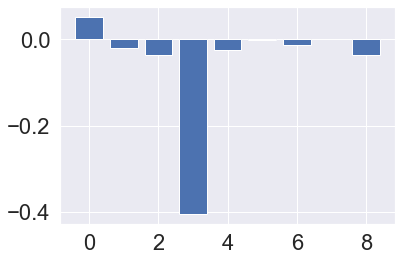

Alpha: 50.0
              precision    recall  f1-score   support

         210       0.96      0.77      0.85        30
         220       0.33      0.89      0.48         9
         225       0.91      0.65      0.75        31

    accuracy                           0.73        70
   macro avg       0.73      0.77      0.70        70
weighted avg       0.86      0.73      0.76        70

Feature: 0, Score: -0.00418
Feature: 1, Score: -0.00047
Feature: 2, Score: -0.05300
Feature: 3, Score: -0.40671
Feature: 4, Score: 0.00770
Feature: 5, Score: -0.02625
Feature: 6, Score: -0.03014
Feature: 7, Score: 0.01956
Feature: 8, Score: -0.08023


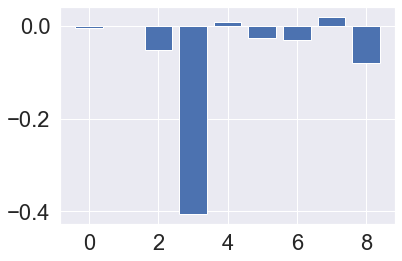

Alpha: 50.0
              precision    recall  f1-score   support

         210       0.87      0.71      0.78        28
         220       0.21      0.50      0.29        10
         225       0.78      0.56      0.65        32

    accuracy                           0.61        70
   macro avg       0.62      0.59      0.58        70
weighted avg       0.74      0.61      0.65        70

Feature: 0, Score: 0.01070
Feature: 1, Score: -0.01013
Feature: 2, Score: -0.01756
Feature: 3, Score: -0.46920
Feature: 4, Score: 0.02067
Feature: 5, Score: -0.04165
Feature: 6, Score: -0.00664
Feature: 7, Score: -0.01547
Feature: 8, Score: -0.11534


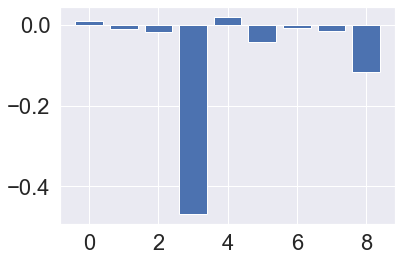

Alpha: 50.0
              precision    recall  f1-score   support

         210       0.83      0.70      0.76        27
         220       0.04      0.25      0.07         4
         225       0.78      0.46      0.58        39

    accuracy                           0.54        70
   macro avg       0.55      0.47      0.47        70
weighted avg       0.76      0.54      0.62        70



In [58]:
# Split in K folds and standardize
cv = StratifiedKFold(n_splits=K, shuffle=True, random_state=13)
for train_index, test_index in cv.split(X, y):
    X_train, X_test = X[train_index], X[test_index]
    scaler = StandardScaler()
    X_train_scaled = scaler.fit_transform(X_train)
    X_test_scaled = scaler.transform(X_test)
    y_train, y_test = y[train_index], y[test_index]
    
    # Optimize Ridge hyperparameter λ 
    hyperparameters = {"alpha": 10**np.linspace(10,-2,10)*0.5} 
    gkf=StratifiedKFold(n_splits=5, shuffle=True, random_state=13)
    Grid = GridSearchCV(RidgeClassifier(), hyperparameters, scoring='accuracy', cv=gkf, verbose=0, n_jobs=-1)
    Grid.fit(X_train_scaled, y_train)
    
    # Initialize model
    RC = RidgeClassifier(alpha=Grid.best_params_['alpha'], random_state=13)

    # Fit model 
    RC.fit(X_train_scaled,y_train)

    # Predict output
    y_pred = RC.predict(X_test_scaled)

    # Summarize feature importance
    importance = RC.coef_[0]
    for i,v in enumerate(importance):
        print('Feature: %0d, Score: %.5f' % (i,v))
    plt.bar([x for x in range(len(importance))], importance)
    plt.show()
    
    # Output
    print("Alpha:",Grid.best_params_['alpha'])
    print(classification_report(y_pred, y_test))
    
    # Model performance
    accuracy = float(classification_report(y_pred, y_test)[-123:-119])
    precision = float(classification_report(y_pred, y_test)[-35:-31])
    recall = float(classification_report(y_pred, y_test)[-25:-21])
         
    # Save in dataframe
    row = pd.DataFrame([accuracy, precision, recall, 'ridge', n_channels, table], \
                   index = ['accuracy', 'precision', 'recall', 'classifier', 'n_channels', 'table']).transpose()
    performance = performance.append(row, ignore_index=True)   

## 3. K-nearest neighbors

Feature: 0, Score: -0.05070
Feature: 1, Score: 0.01690
Feature: 2, Score: -0.01690
Feature: 3, Score: -0.00282
Feature: 4, Score: -0.01127
Feature: 5, Score: 0.01972
Feature: 6, Score: -0.01127
Feature: 7, Score: 0.00000
Feature: 8, Score: 0.00845


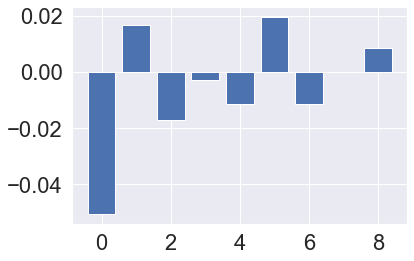

n_neighbors: 11
              precision    recall  f1-score   support

         210       0.88      0.75      0.81        28
         220       0.42      0.50      0.45        20
         225       0.57      0.57      0.57        23

    accuracy                           0.62        71
   macro avg       0.62      0.61      0.61        71
weighted avg       0.65      0.62      0.63        71

Feature: 0, Score: 0.00000
Feature: 1, Score: 0.04507
Feature: 2, Score: 0.00282
Feature: 3, Score: 0.00000
Feature: 4, Score: 0.00000
Feature: 5, Score: 0.00000
Feature: 6, Score: 0.00000
Feature: 7, Score: 0.00000
Feature: 8, Score: 0.00000


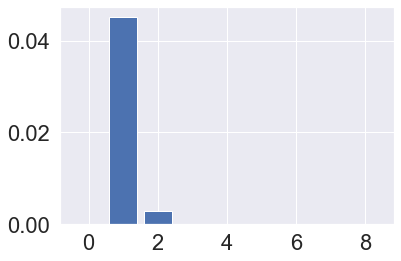

n_neighbors: 5
              precision    recall  f1-score   support

         210       0.75      0.72      0.73        25
         220       0.50      0.55      0.52        22
         225       0.48      0.46      0.47        24

    accuracy                           0.58        71
   macro avg       0.58      0.57      0.57        71
weighted avg       0.58      0.58      0.58        71

Feature: 0, Score: -0.03714
Feature: 1, Score: 0.02286
Feature: 2, Score: -0.02571
Feature: 3, Score: -0.01143
Feature: 4, Score: 0.00000
Feature: 5, Score: -0.02857
Feature: 6, Score: -0.03143
Feature: 7, Score: 0.00000
Feature: 8, Score: 0.00000


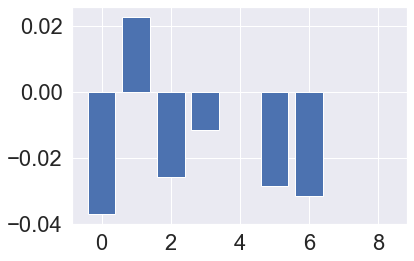

n_neighbors: 1
              precision    recall  f1-score   support

         210       0.79      0.90      0.84        21
         220       0.58      0.56      0.57        25
         225       0.64      0.58      0.61        24

    accuracy                           0.67        70
   macro avg       0.67      0.68      0.67        70
weighted avg       0.66      0.67      0.67        70

Feature: 0, Score: -0.00857
Feature: 1, Score: 0.01143
Feature: 2, Score: 0.00000
Feature: 3, Score: 0.00000
Feature: 4, Score: 0.00000
Feature: 5, Score: 0.00000
Feature: 6, Score: -0.00571
Feature: 7, Score: 0.00000
Feature: 8, Score: 0.00000


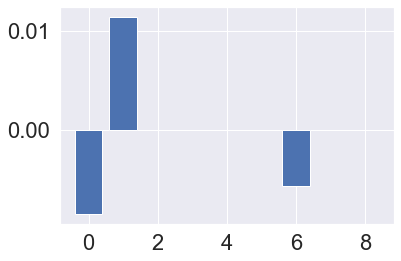

n_neighbors: 7
              precision    recall  f1-score   support

         210       0.87      0.77      0.82        26
         220       0.71      0.63      0.67        27
         225       0.65      0.88      0.75        17

    accuracy                           0.74        70
   macro avg       0.74      0.76      0.74        70
weighted avg       0.75      0.74      0.74        70

Feature: 0, Score: 0.00286
Feature: 1, Score: 0.00000
Feature: 2, Score: 0.00000
Feature: 3, Score: 0.00000
Feature: 4, Score: 0.00000
Feature: 5, Score: 0.00000
Feature: 6, Score: 0.00000
Feature: 7, Score: 0.00000
Feature: 8, Score: 0.00000


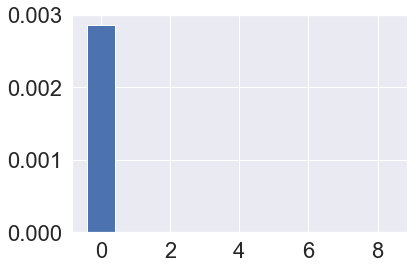

n_neighbors: 1
              precision    recall  f1-score   support

         210       0.61      0.78      0.68        18
         220       0.38      0.43      0.40        21
         225       0.57      0.42      0.48        31

    accuracy                           0.51        70
   macro avg       0.52      0.54      0.52        70
weighted avg       0.52      0.51      0.51        70



In [59]:
# Split in K folds and standardize
cv = StratifiedKFold(n_splits=K, shuffle=True, random_state=13)
for train_index, test_index in cv.split(X, y):
    X_train, X_test = X[train_index], X[test_index]
    scaler = StandardScaler()
    X_train_scaled = scaler.fit_transform(X_train)
    X_test_scaled = scaler.transform(X_test)
    y_train, y_test = y[train_index], y[test_index]
    
    # Optimize hyperparameter K
    hyperparameters = {'n_neighbors':[i for i in range(1,20)]}
    gkf=StratifiedKFold(n_splits=5, shuffle=True, random_state=13)
    Grid = GridSearchCV(KNeighborsClassifier(), hyperparameters, scoring='accuracy', cv=gkf, verbose=0, n_jobs=-1)
    Grid.fit(X_train_scaled, y_train)
        
    # Initialize model
    KNN = KNeighborsClassifier(n_neighbors=Grid.best_params_['n_neighbors'])
    
    # Fit model 
    KNN.fit(X_train_scaled,y_train)

    # Predict output
    y_pred = KNN.predict(X_test_scaled)
    
    # Summarize feature importance
    results = permutation_importance(KNN, X_test, y_test, scoring='accuracy')
    importance = results.importances_mean
    for i,v in enumerate(importance):
        print('Feature: %0d, Score: %.5f' % (i,v))
    plt.bar([x for x in range(len(importance))], importance)
    plt.show()
    
    # Output
    print('n_neighbors:',Grid.best_params_['n_neighbors'])
    print(classification_report(y_pred, y_test))
    
    # Model performance
    accuracy = float(classification_report(y_pred, y_test)[-123:-119])
    precision = float(classification_report(y_pred, y_test)[-35:-31])
    recall = float(classification_report(y_pred, y_test)[-25:-21])
        
    # Save in dataframe
    row = pd.DataFrame([accuracy, precision, recall, 'KNN', n_channels, table], \
                   index = ['accuracy', 'precision', 'recall', 'classifier', 'n_channels', 'table']).transpose()
    performance = performance.append(row, ignore_index=True)   

## 4. Multi-layer perceptron

In [60]:
# Split in K folds and standardize
cv = StratifiedKFold(n_splits=K, shuffle=True, random_state=13)
for train_index, test_index in cv.split(X, y):
    X_train, X_test = X[train_index], X[test_index]
    scaler = StandardScaler()
    X_train_scaled = scaler.fit_transform(X_train)
    X_test_scaled = scaler.transform(X_test)
    y_train, y_test = y[train_index], y[test_index]

    # Optimize hyperparameters
    hyperparameters = {'activation':['identity', 'logistic', 'tanh', 'relu'], 'solver':['lbfgs', 'sgd', 'adam']}
    gkf=StratifiedKFold(n_splits=5, shuffle=True, random_state=13)
    Grid = GridSearchCV(MLPClassifier(), hyperparameters, scoring='accuracy', cv=gkf, verbose=0, n_jobs=-1)
    Grid.fit(X_train_scaled, y_train)
    
    # Initialize model
    MLP = MLPClassifier(hidden_layer_sizes=(150,100,50), max_iter=500, activation = Grid.best_params_['activation'], \
                        solver=Grid.best_params_['solver'], random_state=13)

    # Fit model 
    MLP.fit(X_train_scaled,y_train)

    # Predict output
    y_pred = MLP.predict(X_test_scaled)

    # Output
    print(f"\033[1mActivation function: \033[0m{Grid.best_params_['activation']}")
    print(f"\033[1mSolver: \033[0m{Grid.best_params_['solver']}")
    print(classification_report(y_pred, y_test))
    
    # Model performance
    accuracy = float(classification_report(y_pred, y_test)[-123:-119])
    precision = float(classification_report(y_pred, y_test)[-35:-31])
    recall = float(classification_report(y_pred, y_test)[-25:-21])
     
    # Save in dataframe
    row = pd.DataFrame([accuracy, precision, recall, 'MLP', n_channels, table], \
                   index = ['accuracy', 'precision', 'recall', 'classifier', 'n_channels', 'table']).transpose()
    performance = performance.append(row, ignore_index=True)   

Activation function: logistic
Solver: lbfgs
              precision    recall  f1-score   support

         210       0.88      0.84      0.86        25
         220       0.83      0.74      0.78        27
         225       0.70      0.84      0.76        19

    accuracy                           0.80        71
   macro avg       0.80      0.81      0.80        71
weighted avg       0.81      0.80      0.80        71

Activation function: logistic
Solver: lbfgs
              precision    recall  f1-score   support

         210       0.79      0.90      0.84        21
         220       0.79      0.86      0.83        22
         225       0.91      0.75      0.82        28

    accuracy                           0.83        71
   macro avg       0.83      0.84      0.83        71
weighted avg       0.84      0.83      0.83        71

Activation function: logistic
Solver: lbfgs
              precision    recall  f1-score   support

         210       0.88      0.81      0.84        

## 5. Random forest

Feature: 0, Score: 0.05858
Feature: 1, Score: 0.05649
Feature: 2, Score: 0.05608
Feature: 3, Score: 0.56747
Feature: 4, Score: 0.06528
Feature: 5, Score: 0.05302
Feature: 6, Score: 0.01950
Feature: 7, Score: 0.06208
Feature: 8, Score: 0.06151


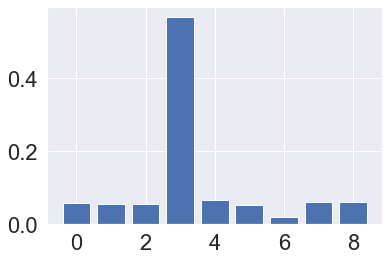

Number of trees: 2000
Maximum depth: 100
Maximum features per node split: sqrt
              precision    recall  f1-score   support

         210       0.96      0.79      0.87        29
         220       0.88      0.78      0.82        27
         225       0.61      0.93      0.74        15

    accuracy                           0.82        71
   macro avg       0.81      0.83      0.81        71
weighted avg       0.85      0.82      0.82        71

Feature: 0, Score: 0.05836
Feature: 1, Score: 0.05840
Feature: 2, Score: 0.06036
Feature: 3, Score: 0.56973
Feature: 4, Score: 0.06316
Feature: 5, Score: 0.05223
Feature: 6, Score: 0.02049
Feature: 7, Score: 0.05712
Feature: 8, Score: 0.06014


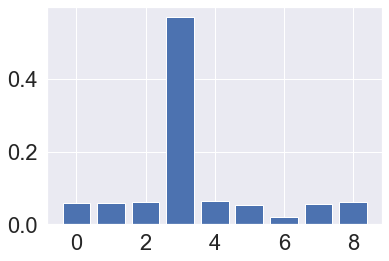

Number of trees: 200
Maximum depth: 32
Maximum features per node split: auto
              precision    recall  f1-score   support

         210       0.79      0.90      0.84        21
         220       0.92      0.88      0.90        25
         225       0.87      0.80      0.83        25

    accuracy                           0.86        71
   macro avg       0.86      0.86      0.86        71
weighted avg       0.86      0.86      0.86        71

Feature: 0, Score: 0.05653
Feature: 1, Score: 0.05981
Feature: 2, Score: 0.06054
Feature: 3, Score: 0.57090
Feature: 4, Score: 0.06786
Feature: 5, Score: 0.05069
Feature: 6, Score: 0.01733
Feature: 7, Score: 0.05765
Feature: 8, Score: 0.05870


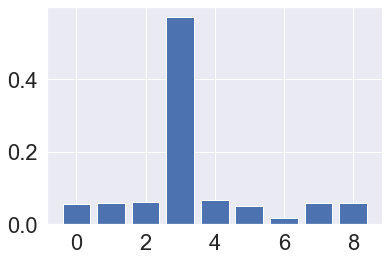

Number of trees: 200
Maximum depth: 77
Maximum features per node split: auto
              precision    recall  f1-score   support

         210       0.96      0.82      0.88        28
         220       0.67      0.94      0.78        17
         225       0.86      0.76      0.81        25

    accuracy                           0.83        70
   macro avg       0.83      0.84      0.82        70
weighted avg       0.85      0.83      0.83        70

Feature: 0, Score: 0.06086
Feature: 1, Score: 0.06263
Feature: 2, Score: 0.05886
Feature: 3, Score: 0.58967
Feature: 4, Score: 0.05630
Feature: 5, Score: 0.04380
Feature: 6, Score: 0.01505
Feature: 7, Score: 0.05609
Feature: 8, Score: 0.05674


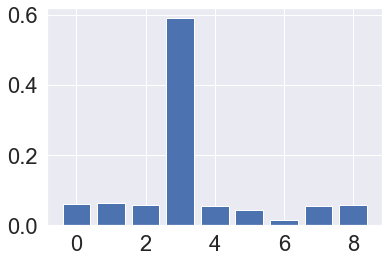

Number of trees: 200
Maximum depth: 100
Maximum features per node split: sqrt
              precision    recall  f1-score   support

         210       0.83      0.79      0.81        24
         220       0.79      0.79      0.79        24
         225       0.87      0.91      0.89        22

    accuracy                           0.83        70
   macro avg       0.83      0.83      0.83        70
weighted avg       0.83      0.83      0.83        70

Feature: 0, Score: 0.04944
Feature: 1, Score: 0.05813
Feature: 2, Score: 0.05420
Feature: 3, Score: 0.58037
Feature: 4, Score: 0.06776
Feature: 5, Score: 0.05018
Feature: 6, Score: 0.02006
Feature: 7, Score: 0.05997
Feature: 8, Score: 0.05989


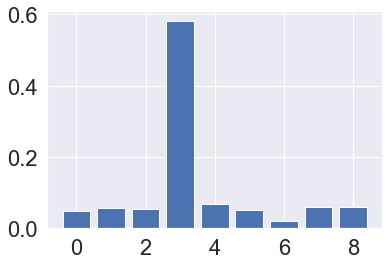

Number of trees: 200
Maximum depth: 100
Maximum features per node split: auto
              precision    recall  f1-score   support

         210       0.83      0.79      0.81        24
         220       0.75      0.90      0.82        20
         225       0.83      0.73      0.78        26

    accuracy                           0.80        70
   macro avg       0.80      0.81      0.80        70
weighted avg       0.80      0.80      0.80        70

Done in 904.9906504154205 seconds


In [61]:
tic = time.time()

# Split in K folds
cv = StratifiedKFold(n_splits=K, shuffle=True, random_state=13)
for train_index, test_index in cv.split(X, y):
    X_train, X_test = X[train_index], X[test_index]
    y_train, y_test = y[train_index], y[test_index]
        
    # Optimize hyperparameters
    hyperparameters = {"n_estimators": [200, 1000, 2000], \
                       "max_depth": [int(x) for x in np.linspace(10, 100, num = 5)],\
                       "max_features": ['auto', 'sqrt']}
    gkf=StratifiedKFold(n_splits=5, shuffle=True, random_state=13)
    Grid = GridSearchCV(RandomForestClassifier(), hyperparameters, scoring='accuracy', cv=gkf, verbose=0, n_jobs=-1)
    Grid.fit(X_train, y_train)
    
    # Initiating a RF classifier
    RFC = RandomForestClassifier(n_estimators = Grid.best_params_['n_estimators'], \
                                max_depth = Grid.best_params_['max_depth'], \
                                max_features = Grid.best_params_['max_features'], random_state = 13)  

    # Fit model
    RFC.fit(X_train, y_train)
  
    # performing predictions on the test dataset
    y_pred = RFC.predict(X_test)
    
    # Summarize feature importance
    importance = RFC.feature_importances_
    for i,v in enumerate(importance):
        print('Feature: %0d, Score: %.5f' % (i,v))
    plt.bar([x for x in range(len(importance))], importance)
    plt.show()

    # Output
    print(f"\033[1mNumber of trees: \033[0m{Grid.best_params_['n_estimators']}")
    print(f"\033[1mMaximum depth: \033[0m{Grid.best_params_['max_depth']}")
    print(f"\033[1mMaximum features per node split: \033[0m{Grid.best_params_['max_features']}")
    print(classification_report(y_pred, y_test))
    
    # Model performance
    accuracy = float(classification_report(y_pred, y_test)[-123:-119])
    precision = float(classification_report(y_pred, y_test)[-35:-31])
    recall = float(classification_report(y_pred, y_test)[-25:-21])
        
    # Save in dataframe
    row = pd.DataFrame([accuracy, precision, recall, 'RF',  n_channels, table], \
                   index = ['accuracy', 'precision', 'recall', 'classifier', 'n_channels', 'table']).transpose()
    performance = performance.append(row, ignore_index=True)   

print(f'Done in {time.time()-tic} seconds')

# V. Statistics

In [62]:
# Typecast# Typecast dataframe
performance[['classifier', 'n_channels', 'table']] = performance[['classifier', 'n_channels', 'table']].astype('category')
performance[['accuracy', 'precision', 'recall']] = performance[['accuracy', 'precision', 'recall']].astype('float32')

# Save as csv
df.to_csv('df_table4.csv')
performance.to_csv('performance_table4.csv')

# Display
display(performance)
display(df) 
performance[['classifier', 'n_channels', 'table']] = performance[['classifier', 'n_channels', 'table']].astype('category')
performance[['accuracy', 'precision', 'recall']] = performance[['accuracy', 'precision', 'recall']].astype('float32')
display(performance.dtypes)

,accuracy,precision,recall,classifier,n_channels,table
0,0.78,0.84,0.78,log,13,4
1,0.63,0.65,0.63,log,13,4
2,0.57,0.57,0.57,log,13,4
3,0.43,0.42,0.43,log,13,4
4,0.49,0.48,0.49,log,13,4
5,0.67,0.94,0.67,ridge,13,4
6,0.54,0.81,0.54,ridge,13,4
7,0.51,0.56,0.51,ridge,13,4
8,0.40,0.40,0.40,ridge,13,4
9,0.54,0.58,0.54,ridge,13,4


,subject,day,target,offset,knee,exponent,CF,PW,BW,n_peaks,r_squared,error
0,S1,/Day1,210,-2.786069,-1.013677,0.005934,19.586790,0.252773,3.550318,3,0.971973,0.044624
1,S1,/Day1,220,-1.130506,-1.598865,0.205102,21.920685,0.298087,2.000000,3,0.971127,0.049268
2,S1,/Day1,225,-4.173462,-1.000673,0.000297,20.296577,0.213252,4.000000,5,0.969226,0.047616
3,S1,/Day2,210,-3.396288,-1.002890,0.001265,18.440058,0.231410,2.214785,4,0.966493,0.044092
4,S1,/Day2,220,-3.725321,-1.000896,0.000401,22.025690,0.158610,2.000000,4,0.848166,0.071575
...,...,...,...,...,...,...,...,...,...,...,...,...
347,S30,/Day1,210,5.300224,159034.968750,3.265310,21.178347,0.171793,2.000000,4,0.914481,0.045228
348,S30,/Day1,220,1.592971,5.640302,1.131878,22.673483,0.216622,4.000000,3,0.856644,0.066957
349,S30,/Day1,225,4.014735,6070.843750,2.574229,22.298964,0.354434,2.000000,3,0.879738,0.067575
350,S30,/Day2,220,4.742969,40169.644531,2.990928,21.825737,0.407879,2.000000,2,0.747785,0.094793


accuracy       float32
precision      float32
recall         float32
classifier    category
n_channels    category
table         category
dtype: object

In [63]:
# Mean
display(pd.concat([performance.groupby(['classifier', 'n_channels']).agg({'accuracy': ['mean']}),\
                   performance.groupby(['classifier', 'n_channels']).agg({'precision': ['mean']}),\
                   performance.groupby(['classifier', 'n_channels']).agg({'recall': ['mean']})], axis=1))

# Standard error
print('log 13')
display(np.std(performance[(performance['classifier']=='log') & (performance['n_channels']==13)], axis=0)/sqrt(5))
print('log 3')
display(np.std(performance[(performance['classifier']=='log') & (performance['n_channels']==3)], axis=0)/sqrt(5))

print('Ridge 13')
display(np.std(performance[(performance['classifier']=='ridge') & (performance['n_channels']==13)], axis=0)/sqrt(5))
print('Ridge 3')
display(np.std(performance[(performance['classifier']=='ridge') & (performance['n_channels']==3)], axis=0)/sqrt(5))

print('KNN 13')
display(np.std(performance[(performance['classifier']=='KNN') & (performance['n_channels']==13)], axis=0)/sqrt(5))
print('KNN 3')
display(np.std(performance[(performance['classifier']=='KNN') & (performance['n_channels']==3)], axis=0)/sqrt(5))

print('MLP 13')
display(np.std(performance[(performance['classifier']=='MLP') & (performance['n_channels']==13)], axis=0)/sqrt(5))
print('MLP 3')
display(np.std(performance[(performance['classifier']=='MLP') & (performance['n_channels']==3)], axis=0)/sqrt(5))

print('RF 13')
display(np.std(performance[(performance['classifier']=='RF') & (performance['n_channels']==13)], axis=0)/sqrt(5))
print('RF 3')
display(np.std(performance[(performance['classifier']=='RF') & (performance['n_channels']==3)], axis=0)/sqrt(5))

accuracy precision recall
                          mean      mean   mean
classifier n_channels                          
KNN        3             0.624     0.632  0.624
           13            0.592     0.612  0.592
MLP        3             0.794     0.802  0.794
           13            0.730     0.748  0.730
RF         3             0.828     0.838  0.828
           13            0.776     0.808  0.776
log        3             0.706     0.740  0.706
           13            0.580     0.592  0.580
ridge      3             0.638     0.754  0.638
           13            0.532     0.658  0.532

log 13


accuracy     0.054111
precision    0.065568
recall       0.054111
dtype: float64

log 3


accuracy     0.013145
precision    0.018547
recall       0.013145
dtype: float64

Ridge 13


accuracy     0.038512
precision    0.085995
recall       0.038512
dtype: float64

Ridge 3


accuracy     0.038720
precision    0.031445
recall       0.038720
dtype: float64

KNN 13


accuracy     0.029719
precision    0.037030
recall       0.029719
dtype: float64

KNN 3


accuracy     0.034940
precision    0.034802
recall       0.034940
dtype: float64

MLP 13


accuracy     0.007483
precision    0.008672
recall       0.007483
dtype: float64

MLP 3


accuracy     0.01004
precision    0.00955
recall       0.01004
dtype: float64

RF 13


accuracy     0.023082
precision    0.023221
recall       0.023082
dtype: float64

RF 3


accuracy     0.008672
precision    0.009550
recall       0.008672
dtype: float64

In [64]:
## ANOVA and Tukey's test 
# Accuracy
model = ols('accuracy ~ C(classifier) + C(n_channels) + C(classifier):C(n_channels)', data=performance).fit()
display(sm.stats.anova_lm(model, typ=2))
tukey = pairwise_tukeyhsd(endog=performance['accuracy'],
                          groups=performance['classifier'],
                          alpha=0.05)
print(tukey)
tukey = pairwise_tukeyhsd(endog=performance['accuracy'],
                          groups=performance['n_channels'],
                          alpha=0.05)
print(tukey)

# Precision
model = ols('precision ~ C(classifier) + C(n_channels) + C(classifier):C(n_channels)', data=performance).fit()
display(sm.stats.anova_lm(model, typ=2))
tukey = pairwise_tukeyhsd(endog=performance['precision'],
                          groups=performance['classifier'],
                          alpha=0.05)
print(tukey)
tukey = pairwise_tukeyhsd(endog=performance['precision'],
                          groups=performance['n_channels'],
                          alpha=0.05)
print(tukey)

# Recall
model = ols('recall ~ C(classifier) + C(n_channels) + C(classifier):C(n_channels)', data=performance).fit()
display(sm.stats.anova_lm(model, typ=2))
tukey = pairwise_tukeyhsd(endog=performance['recall'],
                          groups=performance['classifier'],
                          alpha=0.05)
print(tukey)
tukey = pairwise_tukeyhsd(endog=performance['recall'],
                          groups=performance['n_channels'],
                          alpha=0.05)
print(tukey)

,sum_sq,df,F,PR(>F)
C(classifier),0.37186,4.0,16.615727,4.237454e-08
C(n_channels),0.07220,1.0,12.904379,8.875415e-04
C(classifier):C(n_channels),0.01514,4.0,0.676497,6.122468e-01
Residual,0.22380,40.0,NaN,NaN


Multiple Comparison of Means - Tukey HSD, FWER=0.05 
group1 group2 meandiff p-adj   lower   upper  reject
----------------------------------------------------
   KNN    MLP    0.154 0.0014  0.0483  0.2597   True
   KNN     RF    0.194  0.001  0.0883  0.2997   True
   KNN    log    0.035 0.8695 -0.0707  0.1407  False
   KNN  ridge   -0.023    0.9 -0.1287  0.0827  False
   MLP     RF     0.04  0.795 -0.0657  0.1457  False
   MLP    log   -0.119 0.0202 -0.2247 -0.0133   True
   MLP  ridge   -0.177  0.001 -0.2827 -0.0713   True
    RF    log   -0.159  0.001 -0.2647 -0.0533   True
    RF  ridge   -0.217  0.001 -0.3227 -0.1113   True
   log  ridge   -0.058 0.5267 -0.1637  0.0477  False
----------------------------------------------------
Multiple Comparison of Means - Tukey HSD, FWER=0.05 
group1 group2 meandiff p-adj   lower   upper  reject
----------------------------------------------------
     3     13   -0.076 0.0212 -0.1402 -0.0118   True
----------------------------------------------

,sum_sq,df,F,PR(>F)
C(classifier),0.263372,4.0,6.421202,0.000434
C(n_channels),0.060552,1.0,5.905208,0.019677
C(classifier):C(n_channels),0.027788,4.0,0.677492,0.611577
Residual,0.410160,40.0,NaN,NaN


Multiple Comparison of Means - Tukey HSD, FWER=0.05 
group1 group2 meandiff p-adj   lower   upper  reject
----------------------------------------------------
   KNN    MLP    0.153 0.0177  0.0192  0.2868   True
   KNN     RF    0.201  0.001  0.0672  0.3348   True
   KNN    log    0.044 0.8731 -0.0898  0.1778  False
   KNN  ridge    0.084 0.3963 -0.0498  0.2178  False
   MLP     RF    0.048  0.826 -0.0858  0.1818  False
   MLP    log   -0.109 0.1589 -0.2428  0.0248  False
   MLP  ridge   -0.069 0.5787 -0.2028  0.0648  False
    RF    log   -0.157 0.0141 -0.2908 -0.0232   True
    RF  ridge   -0.117 0.1122 -0.2508  0.0168  False
   log  ridge     0.04    0.9 -0.0938  0.1738  False
----------------------------------------------------
Multiple Comparison of Means - Tukey HSD, FWER=0.05 
group1 group2 meandiff p-adj   lower   upper  reject
----------------------------------------------------
     3     13  -0.0696 0.0473 -0.1383 -0.0009   True
----------------------------------------------

,sum_sq,df,F,PR(>F)
C(classifier),0.37186,4.0,16.615727,4.237454e-08
C(n_channels),0.07220,1.0,12.904379,8.875415e-04
C(classifier):C(n_channels),0.01514,4.0,0.676497,6.122468e-01
Residual,0.22380,40.0,NaN,NaN


Multiple Comparison of Means - Tukey HSD, FWER=0.05 
group1 group2 meandiff p-adj   lower   upper  reject
----------------------------------------------------
   KNN    MLP    0.154 0.0014  0.0483  0.2597   True
   KNN     RF    0.194  0.001  0.0883  0.2997   True
   KNN    log    0.035 0.8695 -0.0707  0.1407  False
   KNN  ridge   -0.023    0.9 -0.1287  0.0827  False
   MLP     RF     0.04  0.795 -0.0657  0.1457  False
   MLP    log   -0.119 0.0202 -0.2247 -0.0133   True
   MLP  ridge   -0.177  0.001 -0.2827 -0.0713   True
    RF    log   -0.159  0.001 -0.2647 -0.0533   True
    RF  ridge   -0.217  0.001 -0.3227 -0.1113   True
   log  ridge   -0.058 0.5267 -0.1637  0.0477  False
----------------------------------------------------
Multiple Comparison of Means - Tukey HSD, FWER=0.05 
group1 group2 meandiff p-adj   lower   upper  reject
----------------------------------------------------
     3     13   -0.076 0.0212 -0.1402 -0.0118   True
----------------------------------------------